In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
%run -i '../../my_functions/utils.py'
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Read ncbi refseq (base)

In [91]:
df_refseq = pd.read_csv('../../../MSK_patients/Trait_based_analysis/blast_ASV_seq/ncbi_refseq/tblASVTaxonomy_top500hit.csv', index_col=0)
df_refseq = df_refseq[['asv','evalue','kingdom','phylum','class','order','family','genus','species']]
df_refseq.columns = ['ASV','Evalue','Kingdom','Phylum','Class','Order','Family','Genus','Species']
df_refseq.Evalue = np.log10(df_refseq.Evalue)
df_refseq = df_refseq.groupby(['ASV','Kingdom','Phylum','Class','Order','Family','Genus','Species']).mean().reset_index()
df_refseq.Evalue = 10**df_refseq.Evalue
# df_refseq['EvalueCategory'] = df_refseq['Evalue']
# df_refseq.loc[df_refseq.EvalueCategory<1e-100, 'EvalueCategory'] = 0
# df_refseq.loc[(df_refseq.EvalueCategory>=1e-100) & (df_refseq.EvalueCategory<1e-50), 'EvalueCategory'] = 1
# df_refseq.loc[(df_refseq.EvalueCategory>=1e-50) & (df_refseq.EvalueCategory<1e-10), 'EvalueCategory'] = 2
# df_refseq.loc[df_refseq.EvalueCategory>=1e-10, 'EvalueCategory'] = 3
#df_refseq = df_refseq[df_refseq.Evalue<1e-50]
#df_refseq['Refseq'] = True
df_refseq.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ASV   Kingdom      Phylum    Class            Order          Family  \
0  ASV_1  Bacteria  Firmicutes  Bacilli       Bacillales  Planococcaceae   
1  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
2  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
3  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
4  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   

              Genus                  Species         Evalue  
0  Rummeliibacillus  Rummeliibacillus pycnus  5.050000e-120  
1        Aerococcus  Aerococcus sanguinicola  8.340000e-128  
2        Aerococcus          Aerococcus suis  6.490000e-124  
3        Aerococcus        Aerococcus urinae  1.071121e-131  
4        Aerococcus    Aerococcus urinaeequi  6.490000e-124

In [92]:
df_maxEvalue = df_refseq.groupby('ASV')['Evalue'].max().to_frame()
print(len(df_maxEvalue.index), len(df_maxEvalue[df_maxEvalue.Evalue<1e-50]), len(df_maxEvalue[df_maxEvalue.Evalue<1e-100]))

17890 16888 3413


# Read silva classification

In [93]:
df_silva = pd.read_csv('../silva/taxonomy_MSK_ASV_10212020_silva.csv')
df_silva = df_silva[df_silva.Species.notnull()]
df_silva = df_silva[['Unnamed: 0','Kingdom','Phylum','Class','Order','Family','Genus','Species']]
df_silva.columns = ['ASV','Kingdom','Phylum','Class','Order','Family','Genus','Species']
lines = []
for asv,k,p,c,o,f,g,s in zip(df_silva['ASV'], df_silva['Kingdom'], df_silva['Phylum'], df_silva['Class'], df_silva['Order'], df_silva['Family'], df_silva['Genus'], df_silva['Species']):
    for s1 in s.split('/'):
        lines.append([asv,k,p,c,o,f,g,g+' '+s1])
df_silva = pd.DataFrame(lines, columns=['ASV','Kingdom','Phylum','Class','Order','Family','Genus','Species'])
df_silva['Silva'] = True
df_silva = df_silva[['ASV','Species','Silva']]
df_silva.head()

ASV                   Species  Silva
0   ASV_6357       Treponema denticola   True
1  ASV_17221  Treponema succinifaciens   True
2   ASV_1271        Campylobacter coli   True
3   ASV_1271      Campylobacter jejuni   True
4   ASV_6188    Campylobacter concisus   True

In [94]:
# are there any ASV in silva that has not been identified by refseq?
set(df_silva.ASV)-set(df_refseq.ASV)

set()

In [95]:
#df_all = pd.merge(df_refseq, df_silva, left_on=['ASV','Kingdom','Phylum','Class','Order','Family','Genus','Species'], right_on=['ASV','Kingdom','Phylum','Class','Order','Family','Genus','Species'], how='outer').fillna(False)
df_all = pd.merge(df_refseq, df_silva, left_on=['ASV','Species'], right_on=['ASV','Species'], how='left').fillna(False)
#df_all.loc[df_all.Evalue==False,'Evalue'] = np.nan
df_all.head()

ASV   Kingdom      Phylum    Class            Order          Family  \
0  ASV_1  Bacteria  Firmicutes  Bacilli       Bacillales  Planococcaceae   
1  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
2  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
3  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
4  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   

              Genus                  Species         Evalue  Silva  
0  Rummeliibacillus  Rummeliibacillus pycnus  5.050000e-120  False  
1        Aerococcus  Aerococcus sanguinicola  8.340000e-128  False  
2        Aerococcus          Aerococcus suis  6.490000e-124  False  
3        Aerococcus        Aerococcus urinae  1.071121e-131  False  
4        Aerococcus    Aerococcus urinaeequi  6.490000e-124  False

# Read HMP catalog

In [100]:
df_hmp = pd.read_csv('../HMP/project_catalog_taxon_added_10222020.csv', index_col=0)
df_hmp = df_hmp[['Species','HMP Isolation Body Site']].drop_duplicates()
df_hmp.columns = ['Species','BodySite']
df_hmp = df_hmp.groupby('Species')['BodySite'].agg(','.join).reset_index()
df_hmp = df_hmp[df_hmp.Species!='<not present>']
df_hmp['HMP'] = [True if 'gastrointestinal_tract' in b else False for b in df_hmp['BodySite']]
df_hmp.head()

Species                BodySite  \
1                            Abiotrophia defectiva                    oral   
2                        Abiotrophia sp. HMSC24B09                 airways   
3  Acetanaerobacterium sp. hmp_mda_pilot_jcvi_0106  gastrointestinal_tract   
4  Acetanaerobacterium sp. hmp_mda_pilot_jcvi_0107  gastrointestinal_tract   
5  Acetanaerobacterium sp. hmp_mda_pilot_jcvi_0109  gastrointestinal_tract   

     HMP  
1  False  
2  False  
3   True  
4   True  
5   True

In [101]:
df_all = pd.merge(df_all, df_hmp, left_on='Species', right_on='Species', how='left')
df_all[['HMP']] = df_all[['HMP']].fillna(False)
df_all.head()

ASV   Kingdom      Phylum    Class            Order          Family  \
0  ASV_1  Bacteria  Firmicutes  Bacilli       Bacillales  Planococcaceae   
1  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
2  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
3  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
4  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   

              Genus                  Species         Evalue  Silva  \
0  Rummeliibacillus  Rummeliibacillus pycnus  5.050000e-120  False   
1        Aerococcus  Aerococcus sanguinicola  8.340000e-128  False   
2        Aerococcus          Aerococcus suis  6.490000e-124  False   
3        Aerococcus        Aerococcus urinae  1.071121e-131  False   
4        Aerococcus    Aerococcus urinaeequi  6.490000e-124  False   

           BodySite    HMP  
0               NaN  False  
1               NaN  False  
2               NaN  False  
3  urogenital_tract  False  
4               NaN  False

# Read unified human gastrointestinal genome catalog

In [102]:
df_uhgg = pd.read_excel('../UHGP/41587_2020_603_MOESM3_ESM.xlsx', index_col=0)
df_uhgg = df_uhgg[['Taxonomy lineage (NCBI)']]
df_uhgg = df_uhgg[df_uhgg['Taxonomy lineage (NCBI)'].notnull()]
all_uhgg_species = []
for s in df_uhgg['Taxonomy lineage (NCBI)']:
    s1 = s.split(';s__')[1]
    if len(s1.strip())!=0:
        all_uhgg_species.append(s1.strip())
all_uhgg_species = list(set(all_uhgg_species))
df_uhgg = pd.DataFrame(all_uhgg_species, columns=['Species'])
df_uhgg['UHGG'] = True
df_uhgg.head()

Species  UHGG
0            Enterobacter kobei  True
1         Yersinia kristensenii  True
2          Victivallis vadensis  True
3                Sneathia amnii  True
4  Gracilibacillus massiliensis  True

In [103]:
df_all = pd.merge(df_all, df_uhgg, left_on='Species', right_on='Species', how='left')
df_all[['UHGG']] = df_all[['UHGG']].fillna(False)
df_all.head()

ASV   Kingdom      Phylum    Class            Order          Family  \
0  ASV_1  Bacteria  Firmicutes  Bacilli       Bacillales  Planococcaceae   
1  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
2  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
3  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
4  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   

              Genus                  Species         Evalue  Silva  \
0  Rummeliibacillus  Rummeliibacillus pycnus  5.050000e-120  False   
1        Aerococcus  Aerococcus sanguinicola  8.340000e-128  False   
2        Aerococcus          Aerococcus suis  6.490000e-124  False   
3        Aerococcus        Aerococcus urinae  1.071121e-131  False   
4        Aerococcus    Aerococcus urinaeequi  6.490000e-124  False   

           BodySite    HMP   UHGG  
0               NaN  False  False  
1               NaN  False  False  
2               NaN  False  False  
3  urogenital_tract  False  False  
4               NaN  False  False

# Read NJS16

In [104]:
df_njs16 = pd.read_csv('../NJS16/njs16_taxid.txt', sep='\t\|\t')
df_njs16 = df_njs16[df_njs16.name.notnull()]
all_njs16_species = list(set(list(df_njs16.name)+list(df_njs16['preferred name'])))
all_njs16_species_new = []
for x in all_njs16_species:
    if 'host' in x:
        continue
    if '(' in x:
        x1 = x.split('(')[0]
        x2 = x.split('(')[1].split(')')[0]
        all_njs16_species_new.append(x1.strip())
        all_njs16_species_new.append(x2.strip())
    else:
        all_njs16_species_new.append(x.strip())
all_njs16_species_new = list(set(all_njs16_species_new))
df_njs16 = pd.DataFrame(all_njs16_species_new,columns=['Species'])
df_njs16 = df_njs16[(df_njs16.Species != '|') & (df_njs16.Species != '')]
df_njs16['NJS16'] = True
df_njs16.head()

<ipython-input-104-b70e4a26d81a>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_njs16 = pd.read_csv('../NJS16/njs16_taxid.txt', sep='\t\|\t')


Species  NJS16
0               Rhizobium leguminosarum   True
1                   Ruminococcus gnavus   True
3  Candidatus Baumannia cicadellinicola   True
4           Methylobacterium extorquens   True
5                Bacteroides helcogenes   True

In [105]:
df_all = pd.merge(df_all, df_njs16, left_on='Species', right_on='Species', how='left')
df_all[['NJS16']] = df_all[['NJS16']].fillna(False)
df_all.head()

ASV   Kingdom      Phylum    Class            Order          Family  \
0  ASV_1  Bacteria  Firmicutes  Bacilli       Bacillales  Planococcaceae   
1  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
2  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
3  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
4  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   

              Genus                  Species         Evalue  Silva  \
0  Rummeliibacillus  Rummeliibacillus pycnus  5.050000e-120  False   
1        Aerococcus  Aerococcus sanguinicola  8.340000e-128  False   
2        Aerococcus          Aerococcus suis  6.490000e-124  False   
3        Aerococcus        Aerococcus urinae  1.071121e-131  False   
4        Aerococcus    Aerococcus urinaeequi  6.490000e-124  False   

           BodySite    HMP   UHGG  NJS16  
0               NaN  False  False  False  
1               NaN  False  False  False  
2               NaN  False  False  False  
3  urogenital_tract  False  False  False  
4               NaN  False  False  False

# Combine HMP, UHGG and NJS16

In [106]:
df_all['HMPxUHGGxNJS16'] = df_all['HMP'] | df_all['UHGG'] | df_all['NJS16']
df_all.head()

ASV   Kingdom      Phylum    Class            Order          Family  \
0  ASV_1  Bacteria  Firmicutes  Bacilli       Bacillales  Planococcaceae   
1  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
2  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
3  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   
4  ASV_1  Bacteria  Firmicutes  Bacilli  Lactobacillales   Aerococcaceae   

              Genus                  Species         Evalue  Silva  \
0  Rummeliibacillus  Rummeliibacillus pycnus  5.050000e-120  False   
1        Aerococcus  Aerococcus sanguinicola  8.340000e-128  False   
2        Aerococcus          Aerococcus suis  6.490000e-124  False   
3        Aerococcus        Aerococcus urinae  1.071121e-131  False   
4        Aerococcus    Aerococcus urinaeequi  6.490000e-124  False   

           BodySite    HMP   UHGG  NJS16  HMPxUHGGxNJS16  
0               NaN  False  False  False           False  
1               NaN  False  False  False           False  
2               NaN  False  False  False           False  
3  urogenital_tract  False  False  False           False  
4               NaN  False  False  False           False

# Read metagenomics profiles

In [ ]:
df_mgm = pd.read_csv('../../metagenomics/kraken2/relative_abundance/metagenomics_kraken2_relative_abundance.csv', index_col=0)
# keep only species
taxa_to_keep = []
rename = {}
for t in df_mgm.index:
    if '|s__' in t:
        taxa_to_keep.append(t)
        rename.update({t:t.split('|s__')[1].replace('_',' ')})
df_mgm = df_mgm.loc[taxa_to_keep]
df_mgm = df_mgm.rename(rename)
df_mgm = df_mgm/100
df_mgm.head()

In [ ]:
print(len(df_mgm.index), len(set(df_mgm.index)))

# Read relative abundance

In [ ]:
df_count = get_count_table('../../deidentified_data_tables/counts/tblASVcounts_human_filter.csv', unstacked=False)
df_count = df_count[df_count.SampleID.isin(list(df_mgm.columns))]
print(len(df_mgm.columns), len(set(df_count.SampleID)))
df_rab = get_MSKCC_16S_relative_abundance_table(df_count).transpose()
df_rab = df_rab[(df_rab.T != 0).any()] # remove ASVs that are only zero
df_rab.head()

In [ ]:
df_mgm = df_mgm[df_rab.columns]
df_mgm = df_mgm[(df_mgm.T != 0).any()] # remove taxonomy that are only zero
df_mgm.head()

# Create correlation matrix

In [ ]:
def pearsonr_corr(x,y):
    return pearsonr(x,y)[0]

In [ ]:
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

In [ ]:
def slope_value(x,y):
    model = sm.OLS(np.arange(0,len(temp.index)),np.asarray(temp.values))
results = model.fit()
slope = results.params[0]
p_value = stats.t.sf(results.tvalues[0], results.df_resid)

In [ ]:
def slope_pval(x,y):
    

In [ ]:
df_joint = pd.concat([df_rab, df_mgm]).transpose()
df_corr_pearson = df_joint.corr(method='pearson')

In [ ]:
df_corr_pearson = df_corr_pearson.stack().reset_index()
df_corr_pearson.columns = ['ASV','Species','Value']
df_corr_pearson = df_corr_pearson[df_corr_pearson.ASV.str.contains('ASV_')]
df_corr_pearson = df_corr_pearson[~df_corr_pearson.Species.str.contains('ASV_')]
df_corr_pearson = df_corr_pearson.reset_index(drop=True)
df_corr_pearson

In [ ]:
df_all = pd.merge(df_all, df_corr_pearson, left_on=['ASV','Species'], right_on=['ASV','Species'], how='left')
df_all.columns = ['ASV','Kingdom','Phylum','Class','Order','Family','Genus','Species','Evalue','Silva','BodySite','HMP','UHGG','NJS16','HMPxUHGGxNJS16','Kraken2']
df_all.head()

In [ ]:
# get categorized Kraken2
df_all[['Kraken2Category']] = np.round(df_all[['Kraken2']].fillna(-100)*10).astype(int)
#pd.cut(df_all['Kraken2'], bins = np.concatenate((np.array([-1]),np.linspace(0,1,21))), labels=np.arange(21))
df_all.head()

# Test slope against 1

# Sort

In [26]:
df_all['Evalue'] = -df_all['Evalue']
#df_all['EvalueCategory'] = -df_all['EvalueCategory']
df_all = df_all.sort_values(by=['ASV','HMPxUHGGxNJS16','Kraken2Category','Silva','Evalue','Kraken2'], ascending=False)
df_all['Evalue'] = -df_all['Evalue']
#df_all['EvalueCategory'] = -df_all['EvalueCategory']

In [27]:
df_all.to_csv('taxonomy_MSK_ASV_species_assignment_10222020_raw.csv')

# Save all species to a file

In [28]:
df_all = pd.read_csv('taxonomy_MSK_ASV_species_assignment_10222020_raw.csv.gz', compression='gzip', index_col=0)
df_all.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ASV   Kingdom          Phylum                Class  \
6158230  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158208  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158207  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158274  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158232  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   

                    Order              Family         Genus  \
6158230  Enterobacterales  Enterobacteriaceae    Klebsiella   
6158208  Enterobacterales  Enterobacteriaceae  Enterobacter   
6158207  Enterobacterales  Enterobacteriaceae  Enterobacter   
6158274  Enterobacterales  Enterobacteriaceae     Yokenella   
6158232  Enterobacterales  Enterobacteriaceae    Klebsiella   

                           Species         Evalue  Silva  \
6158230      Klebsiella pneumoniae  1.687149e-169  False   
6158208       Enterobacter cloacae  5.445665e-168  False   
6158207  Enterobacter cancerogenus  1.020000e-166  False   
6158274     Yokenella regensburgei  4.730000e-165  False   
6158232       Klebsiella variicola  1.696349e-164  False   

                                                  BodySite   HMP  UHGG  NJS16  \
6158230  airways,urogenital_tract,gastrointestinal_trac...  True  True   True   
6158208                             gastrointestinal_tract  True  True   True   
6158207                             gastrointestinal_tract  True  True   True   
6158274                             gastrointestinal_tract  True  True  False   
6158232                                                NaN   NaN  True   True   

         HMPxUHGGxNJS16  Kraken2  Kraken2Category  
6158230            True      NaN            -1000  
6158208            True      NaN            -1000  
6158207            True      NaN            -1000  
6158274            True      NaN            -1000  
6158232            True      NaN            -1000

In [29]:
all_species = list(set(df_all['Species']))
print(len(all_species))

14903


In [30]:
with open('all_species_names.txt', 'w') as f:
    for item in all_species:
        f.write("%s\n" % item)

# Save all genus to file

In [73]:
df_all = pd.read_csv('taxonomy_MSK_ASV_species_assignment_10222020_raw.csv.gz', compression='gzip', index_col=0)
df_all.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ASV   Kingdom          Phylum                Class  \
6158230  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158208  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158207  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158226  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158236  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   

                    Order              Family         Genus  \
6158230  Enterobacterales  Enterobacteriaceae    Klebsiella   
6158208  Enterobacterales  Enterobacteriaceae  Enterobacter   
6158207  Enterobacterales  Enterobacteriaceae  Enterobacter   
6158226  Enterobacterales  Enterobacteriaceae    Klebsiella   
6158236  Enterobacterales  Enterobacteriaceae      Kluyvera   

                           Species         Evalue  Silva  \
6158230      Klebsiella pneumoniae  1.687149e-169  False   
6158208       Enterobacter cloacae  5.445665e-168  False   
6158207  Enterobacter cancerogenus  1.020000e-166  False   
6158226       Klebsiella aerogenes  1.020000e-166  False   
6158236        Kluyvera intermedia  5.613276e-166  False   

                                                  BodySite    HMP  UHGG  \
6158230  airways,urogenital_tract,gastrointestinal_trac...   True  True   
6158208                             gastrointestinal_tract   True  True   
6158207                             gastrointestinal_tract   True  True   
6158226                                                NaN  False  True   
6158236                                                NaN  False  True   

         NJS16  HMPxUHGGxNJS16  Kraken2  Kraken2Category  
6158230   True            True      NaN            -1000  
6158208   True            True      NaN            -1000  
6158207   True            True      NaN            -1000  
6158226  False            True      NaN            -1000  
6158236  False            True      NaN            -1000

In [74]:
all_genus = list(set(df_all['Genus']))
print(len(all_genus))

2953


In [75]:
with open('all_genus_names.txt', 'w') as f:
    for item in all_genus:
        f.write("%s\n" % item)

# Save all family to file

In [84]:
df_all = pd.read_csv('taxonomy_MSK_ASV_species_assignment_10222020_raw.csv.gz', compression='gzip', index_col=0)
df_all.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ASV   Kingdom          Phylum                Class  \
6158230  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158208  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158207  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158226  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158236  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   

                    Order              Family         Genus  \
6158230  Enterobacterales  Enterobacteriaceae    Klebsiella   
6158208  Enterobacterales  Enterobacteriaceae  Enterobacter   
6158207  Enterobacterales  Enterobacteriaceae  Enterobacter   
6158226  Enterobacterales  Enterobacteriaceae    Klebsiella   
6158236  Enterobacterales  Enterobacteriaceae      Kluyvera   

                           Species         Evalue  Silva  \
6158230      Klebsiella pneumoniae  1.687149e-169  False   
6158208       Enterobacter cloacae  5.445665e-168  False   
6158207  Enterobacter cancerogenus  1.020000e-166  False   
6158226       Klebsiella aerogenes  1.020000e-166  False   
6158236        Kluyvera intermedia  5.613276e-166  False   

                                                  BodySite    HMP  UHGG  \
6158230  airways,urogenital_tract,gastrointestinal_trac...   True  True   
6158208                             gastrointestinal_tract   True  True   
6158207                             gastrointestinal_tract   True  True   
6158226                                                NaN  False  True   
6158236                                                NaN  False  True   

         NJS16  HMPxUHGGxNJS16  Kraken2  Kraken2Category  
6158230   True            True      NaN            -1000  
6158208   True            True      NaN            -1000  
6158207   True            True      NaN            -1000  
6158226  False            True      NaN            -1000  
6158236  False            True      NaN            -1000

In [85]:
all_family = list(set(df_all['Family']))
print(len(all_family))

497


In [86]:
with open('all_family_names.txt', 'w') as f:
    for item in all_family:
        f.write("%s\n" % item)

# Save all phylum to file

In [87]:
df_all = pd.read_csv('taxonomy_MSK_ASV_species_assignment_10222020_raw.csv.gz', compression='gzip', index_col=0)
df_all.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ASV   Kingdom          Phylum                Class  \
6158230  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158208  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158207  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158226  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158236  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   

                    Order              Family         Genus  \
6158230  Enterobacterales  Enterobacteriaceae    Klebsiella   
6158208  Enterobacterales  Enterobacteriaceae  Enterobacter   
6158207  Enterobacterales  Enterobacteriaceae  Enterobacter   
6158226  Enterobacterales  Enterobacteriaceae    Klebsiella   
6158236  Enterobacterales  Enterobacteriaceae      Kluyvera   

                           Species         Evalue  Silva  \
6158230      Klebsiella pneumoniae  1.687149e-169  False   
6158208       Enterobacter cloacae  5.445665e-168  False   
6158207  Enterobacter cancerogenus  1.020000e-166  False   
6158226       Klebsiella aerogenes  1.020000e-166  False   
6158236        Kluyvera intermedia  5.613276e-166  False   

                                                  BodySite    HMP  UHGG  \
6158230  airways,urogenital_tract,gastrointestinal_trac...   True  True   
6158208                             gastrointestinal_tract   True  True   
6158207                             gastrointestinal_tract   True  True   
6158226                                                NaN  False  True   
6158236                                                NaN  False  True   

         NJS16  HMPxUHGGxNJS16  Kraken2  Kraken2Category  
6158230   True            True      NaN            -1000  
6158208   True            True      NaN            -1000  
6158207   True            True      NaN            -1000  
6158226  False            True      NaN            -1000  
6158236  False            True      NaN            -1000

In [88]:
all_phylum = list(set(df_all['Phylum']))
print(len(all_phylum))

42


In [89]:
with open('all_phylum_names.txt', 'w') as f:
    for item in all_phylum:
        f.write("%s\n" % item)

# Check for abundant ASVs

In [34]:
df_all = pd.read_csv('taxonomy_MSK_ASV_species_assignment_10222020_raw.csv.gz', compression='gzip', index_col=0)

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [38]:
df_all[df_all.ASV=='ASV_2'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
1486052  ASV_2  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1486047  ASV_2  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1486059  ASV_2  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1485798  ASV_2  Bacteria  Firmicutes  Bacilli       Bacillales   
1485840  ASV_2  Bacteria  Firmicutes  Bacilli       Bacillales   
1485916  ASV_2  Bacteria  Firmicutes  Bacilli       Bacillales   
1486031  ASV_2  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1485884  ASV_2  Bacteria  Firmicutes  Bacilli       Bacillales   
1486044  ASV_2  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1486049  ASV_2  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                  Family         Genus                 Species         Evalue  \
1486052  Enterococcaceae  Enterococcus      Enterococcus hirae  2.810000e-172   
1486047  Enterococcaceae  Enterococcus    Enterococcus faecium  1.549332e-171   
1486059  Enterococcaceae  Enterococcus    Enterococcus mundtii  1.549332e-171   
1485798      Bacillaceae      Bacillus         Bacillus cereus  1.050000e-146   
1485840      Bacillaceae      Bacillus  Bacillus licheniformis  1.050000e-146   
1485916     Listeriaceae      Listeria  Listeria monocytogenes  4.880000e-145   
1486031  Enterococcaceae  Enterococcus      Enterococcus avium  1.310000e-170   
1485884      Bacillaceae      Bacillus  Bacillus thuringiensis  1.050000e-146   
1486044  Enterococcaceae  Enterococcus     Enterococcus durans  2.810000e-172   
1486049  Enterococcaceae  Enterococcus     Enterococcus gilvus  1.310000e-170   

         Silva                                           BodySite    HMP  \
1486052   True                                                NaN  False   
1486047   True  blood,gastrointestinal_tract,unknown,urogenita...   True   
1486059   True                                                NaN  False   
1485798  False                                                NaN  False   
1485840  False                                                NaN  False   
1485916  False                                            unknown  False   
1486031  False                                                NaN  False   
1485884  False                                                NaN  False   
1486044   True                                                NaN  False   
1486049  False                                                NaN  False   

         UHGG  NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
1486052  True  False            True  0.879411                9  
1486047  True   True            True  0.945884                9  
1486059  True  False            True  0.925604                9  
1485798  True   True            True  0.544380                5  
1485840  True   True            True  0.521356                5  
1485916  True   True            True  0.536444                5  
1486031  True  False            True  0.266059                3  
1485884  True   True            True  0.308913                3  
1486044  True  False            True  0.211405                2  
1486049  True  False            True  0.154341                2

In [39]:
df_all[df_all.ASV=='ASV_8'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
5831765  ASV_8  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5831692  ASV_8  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5831752  ASV_8  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5831694  ASV_8  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5831763  ASV_8  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5831769  ASV_8  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5831758  ASV_8  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5831751  ASV_8  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5831699  ASV_8  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5831737  ASV_8  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                   Family          Genus                       Species  \
5831765  Streptococcaceae  Streptococcus    Streptococcus thermophilus   
5831692  Streptococcaceae  Streptococcus    Streptococcus dysgalactiae   
5831752  Streptococcaceae  Streptococcus        Streptococcus pyogenes   
5831694  Streptococcaceae  Streptococcus            Streptococcus equi   
5831763  Streptococcaceae  Streptococcus            Streptococcus suis   
5831769  Streptococcaceae  Streptococcus          Streptococcus uberis   
5831758  Streptococcaceae  Streptococcus      Streptococcus salivarius   
5831751  Streptococcaceae  Streptococcus  Streptococcus pseudoporcinus   
5831699  Streptococcaceae  Streptococcus    Streptococcus gallolyticus   
5831737  Streptococcaceae  Streptococcus   Streptococcus parasanguinis   

                Evalue  Silva                 BodySite    HMP   UHGG  NJS16  \
5831765  6.882514e-171  False                      NaN  False   True   True   
5831692  2.920759e-142  False                     oral  False  False   True   
5831752  1.050000e-141  False  airways,oral,blood,skin  False  False   True   
5831694  3.769973e-146  False                      NaN  False  False   True   
5831763  2.200000e-163  False                      NaN  False  False   True   
5831769  1.030000e-156  False                      NaN  False  False   True   
5831758  1.010000e-171  False                     skin  False   True   True   
5831751  2.230000e-153  False         urogenital_tract  False  False   True   
5831699  1.050000e-146  False                    heart  False  False   True   
5831737  2.210000e-158  False     oral,unknown,airways  False   True   True   

         HMPxUHGGxNJS16   Kraken2  Kraken2Category  
5831765            True  0.823319                8  
5831692            True  0.678020                7  
5831752            True  0.597258                6  
5831694            True  0.482452                5  
5831763            True  0.439998                4  
5831769            True  0.398414                4  
5831758            True  0.283274                3  
5831751            True  0.336623                3  
5831699            True  0.257017                3  
5831737            True  0.159428                2

In [40]:
df_all[df_all.ASV=='ASV_19'].head(10)

ASV   Kingdom      Phylum             Class               Order  \
1385364  ASV_19  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
1385374  ASV_19  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
1385341  ASV_19  Bacteria  Firmicutes        Clostridia       Clostridiales   
1385385  ASV_19  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
1385362  ASV_19  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
1385274  ASV_19  Bacteria  Firmicutes           Bacilli     Lactobacillales   
1385322  ASV_19  Bacteria  Firmicutes           Bacilli     Lactobacillales   
1385269  ASV_19  Bacteria  Firmicutes           Bacilli     Lactobacillales   
1385271  ASV_19  Bacteria  Firmicutes           Bacilli     Lactobacillales   
1385328  ASV_19  Bacteria  Firmicutes           Bacilli     Lactobacillales   

                        Family                   Genus  \
1385364    Erysipelotrichaceae  Erysipelatoclostridium   
1385374    Erysipelotrichaceae            Faecalitalea   
1385341  Peptostreptococcaceae         Paraclostridium   
1385385    Erysipelotrichaceae            Turicibacter   
1385362    Erysipelotrichaceae  Erysipelatoclostridium   
1385274        Enterococcaceae            Enterococcus   
1385322        Enterococcaceae              Vagococcus   
1385269        Enterococcaceae            Enterococcus   
1385271        Enterococcaceae            Enterococcus   
1385328       Streptococcaceae           Streptococcus   

                                Species         Evalue  Silva  \
1385364          [Clostridium] innocuum  7.700000e-163  False   
1385374       Faecalitalea cylindroides  6.334667e-119  False   
1385341    Paraclostridium bifermentans   9.541875e-71  False   
1385385          Turicibacter sanguinis   8.620000e-83  False   
1385362  Erysipelatoclostridium ramosum   1.440000e-80  False   
1385274             Enterococcus gilvus   3.120000e-77  False   
1385322              Vagococcus teuberi   3.120000e-77  False   
1385269             Enterococcus durans   3.120000e-77  False   
1385271           Enterococcus faecalis   1.450000e-75  False   
1385328            Streptococcus mutans   6.462765e-75  False   

                                                  BodySite    HMP   UHGG  \
1385364                     gastrointestinal_tract,unknown   True   True   
1385374                             gastrointestinal_tract   True   True   
1385341                             gastrointestinal_tract   True   True   
1385385                                                NaN  False   True   
1385362                             gastrointestinal_tract   True  False   
1385274                                                NaN  False   True   
1385322                                                NaN  False   True   
1385269                                                NaN  False   True   
1385271  urogenital_tract,oral,gastrointestinal_tract,u...   True   True   
1385328                                            unknown  False   True   

         NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
1385364  False            True  0.633653                6  
1385374  False            True  0.125647                1  
1385341  False            True  0.087583                1  
1385385  False            True  0.049123                0  
1385362  False            True -0.008873                0  
1385274  False            True  0.004506                0  
1385322  False            True -0.034494                0  
1385269  False            True -0.048270                0  
1385271   True            True -0.031089                0  
1385328   True            True -0.027299                0

In [122]:
df_all[df_all.ASV=='ASV_6'].head(10)

ASV   Kingdom      Phylum             Class               Order  \
4941458  ASV_6  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
4941460  ASV_6  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
4941431  ASV_6  Bacteria  Firmicutes           Bacilli     Lactobacillales   
4941247  ASV_6  Bacteria  Firmicutes           Bacilli          Bacillales   
4941470  ASV_6  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
4941357  ASV_6  Bacteria  Firmicutes           Bacilli     Lactobacillales   
4941417  ASV_6  Bacteria  Firmicutes           Bacilli     Lactobacillales   
4941221  ASV_6  Bacteria  Firmicutes           Bacilli          Bacillales   
4941211  ASV_6  Bacteria  Firmicutes           Bacilli          Bacillales   
4941410  ASV_6  Bacteria  Firmicutes           Bacilli     Lactobacillales   

                      Family                   Genus  \
4941458  Erysipelotrichaceae  Erysipelatoclostridium   
4941460  Erysipelotrichaceae  Erysipelatoclostridium   
4941431     Streptococcaceae             Lactococcus   
4941247     Paenibacillaceae           Brevibacillus   
4941470  Erysipelotrichaceae            Faecalitalea   
4941357      Enterococcaceae            Enterococcus   
4941417     Lactobacillaceae           Lactobacillus   
4941221          Bacillaceae                Bacillus   
4941211          Bacillaceae                Bacillus   
4941410     Lactobacillaceae           Lactobacillus   

                                Species         Evalue  Silva  \
4941458  Erysipelatoclostridium ramosum  1.670000e-169   True   
4941460          [Clostridium] innocuum   3.140000e-82  False   
4941431              Lactococcus lactis   2.480000e-68  False   
4941247            Brevibacillus brevis   8.930000e-68  False   
4941470       Faecalitalea cylindroides   4.093654e-76  False   
4941357         Enterococcus gallinarum   3.190000e-72  False   
4941417         Lactobacillus hilgardii   4.125530e-71  False   
4941221               Bacillus mycoides   1.480000e-70  False   
4941211              Bacillus anthracis   1.480000e-70  False   
4941410          Lactobacillus buchneri   6.900000e-69  False   

                               BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
4941458          gastrointestinal_tract  True  False  False            True   
4941460  gastrointestinal_tract,unknown  True   True  False            True   
4941431                             NaN   NaN   True   True            True   
4941247                             NaN   NaN  False   True            True   
4941470          gastrointestinal_tract  True   True  False            True   
4941357                             NaN   NaN   True   True            True   
4941417          gastrointestinal_tract  True   True   True            True   
4941221                             NaN   NaN  False   True            True   
4941211                             NaN   NaN  False   True            True   
4941410          gastrointestinal_tract  True   True   True            True   

          Kraken2  Kraken2Category  
4941458  0.829194                8  
4941460  0.198729                2  
4941431  0.247958                2  
4941247  0.086866                1  
4941470 -0.016427                0  
4941357 -0.026675                0  
4941417 -0.036903                0  
4941221 -0.021482                0  
4941211 -0.021596                0  
4941410 -0.021528                0

In [123]:
df_all[df_all.ASV=='ASV_16'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
966973  ASV_16  Bacteria  Firmicutes  Bacilli  Lactobacillales   
966900  ASV_16  Bacteria  Firmicutes  Bacilli  Lactobacillales   
966960  ASV_16  Bacteria  Firmicutes  Bacilli  Lactobacillales   
966902  ASV_16  Bacteria  Firmicutes  Bacilli  Lactobacillales   
966907  ASV_16  Bacteria  Firmicutes  Bacilli  Lactobacillales   
966814  ASV_16  Bacteria  Firmicutes  Bacilli  Lactobacillales   
966971  ASV_16  Bacteria  Firmicutes  Bacilli  Lactobacillales   
966977  ASV_16  Bacteria  Firmicutes  Bacilli  Lactobacillales   
966918  ASV_16  Bacteria  Firmicutes  Bacilli  Lactobacillales   
966858  ASV_16  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                  Family          Genus                     Species  \
966973  Streptococcaceae  Streptococcus  Streptococcus thermophilus   
966900  Streptococcaceae  Streptococcus  Streptococcus dysgalactiae   
966960  Streptococcaceae  Streptococcus      Streptococcus pyogenes   
966902  Streptococcaceae  Streptococcus          Streptococcus equi   
966907  Streptococcaceae  Streptococcus  Streptococcus gallolyticus   
966814  Lactobacillaceae  Lactobacillus      Lactobacillus curvatus   
966971  Streptococcaceae  Streptococcus          Streptococcus suis   
966977  Streptococcaceae  Streptococcus        Streptococcus uberis   
966918  Streptococcaceae  Streptococcus   Streptococcus infantarius   
966858  Lactobacillaceae  Lactobacillus         Lactobacillus sakei   

               Evalue  Silva                 BodySite    HMP   UHGG  NJS16  \
966973  3.197530e-169   True                      NaN    NaN   True   True   
966900  2.920759e-142  False                     oral  False  False   True   
966960  1.050000e-141  False  airways,oral,blood,skin  False  False   True   
966902  3.769973e-146  False                      NaN    NaN  False   True   
966907  4.860000e-145  False                    heart  False  False   True   
966814  1.301380e-112  False   gastrointestinal_tract   True   True  False   
966971  1.020000e-161  False                      NaN    NaN  False   True   
966977  1.030000e-156  False                      NaN    NaN  False   True   
966918  2.250000e-148  False   gastrointestinal_tract   True  False   True   
966858  1.611211e-112  False                      NaN    NaN   True   True   

        HMPxUHGGxNJS16   Kraken2  Kraken2Category  
966973            True  0.771634                8  
966900            True  0.569072                6  
966960            True  0.366658                4  
966902            True  0.248432                2  
966907            True  0.224092                2  
966814            True  0.249321                2  
966971            True  0.148255                1  
966977            True  0.147970                1  
966918            True  0.063159                1  
966858            True  0.089651                1

In [124]:
df_all[df_all.ASV=='ASV_3'].head(10)

ASV   Kingdom          Phylum                Class  \
2115959  ASV_3  Bacteria  Proteobacteria  Gammaproteobacteria   
2116011  ASV_3  Bacteria  Proteobacteria  Gammaproteobacteria   
2116009  ASV_3  Bacteria  Proteobacteria  Gammaproteobacteria   
2115958  ASV_3  Bacteria  Proteobacteria  Gammaproteobacteria   
2116010  ASV_3  Bacteria  Proteobacteria  Gammaproteobacteria   
2115957  ASV_3  Bacteria  Proteobacteria  Gammaproteobacteria   
2116019  ASV_3  Bacteria  Proteobacteria  Gammaproteobacteria   
2116008  ASV_3  Bacteria  Proteobacteria  Gammaproteobacteria   
2115934  ASV_3  Bacteria  Proteobacteria  Gammaproteobacteria   
2115936  ASV_3  Bacteria  Proteobacteria  Gammaproteobacteria   

                    Order              Family        Genus  \
2115959  Enterobacterales  Enterobacteriaceae  Escherichia   
2116011  Enterobacterales  Enterobacteriaceae     Shigella   
2116009  Enterobacterales  Enterobacteriaceae     Shigella   
2115958  Enterobacterales  Enterobacteriaceae  Escherichia   
2116010  Enterobacterales  Enterobacteriaceae     Shigella   
2115957  Enterobacterales  Enterobacteriaceae  Escherichia   
2116019  Enterobacterales  Enterobacteriaceae    Yokenella   
2116008  Enterobacterales  Enterobacteriaceae   Salmonella   
2115934  Enterobacterales  Enterobacteriaceae  Citrobacter   
2115936  Enterobacterales  Enterobacteriaceae  Citrobacter   

                        Species         Evalue  Silva  \
2115959  Escherichia fergusonii  1.010000e-171  False   
2116011       Shigella flexneri  1.010000e-171  False   
2116009         Shigella boydii  1.010000e-171  False   
2115958        Escherichia coli  1.304319e-170  False   
2116010    Shigella dysenteriae  4.690000e-170  False   
2115957    Escherichia albertii  4.730000e-165  False   
2116019  Yokenella regensburgei  1.030000e-156  False   
2116008     Salmonella enterica  3.644145e-152  False   
2115934      Citrobacter koseri  7.841797e-168  False   
2115936   Citrobacter rodentium  2.230000e-153  False   

                                                BodySite   HMP   UHGG  NJS16  \
2115959                                              NaN   NaN   True   True   
2116011                                              NaN   NaN  False   True   
2116009                                              NaN   NaN  False   True   
2115958  urogenital_tract,gastrointestinal_tract,unknown  True   True   True   
2116010                                              NaN   NaN  False   True   
2115957                                              NaN   NaN   True   True   
2116019                           gastrointestinal_tract  True   True  False   
2116008                                              NaN   NaN   True   True   
2115934                                              NaN   NaN   True   True   
2115936                                              NaN   NaN  False   True   

         HMPxUHGGxNJS16   Kraken2  Kraken2Category  
2115959            True  0.931197                9  
2116011            True  0.902414                9  
2116009            True  0.901147                9  
2115958            True  0.929499                9  
2116010            True  0.913220                9  
2115957            True  0.930443                9  
2116019            True  0.894985                9  
2116008            True  0.862880                9  
2115934            True  0.821290                8  
2115936            True  0.800120                8

In [125]:
df_all[df_all.ASV=='ASV_104'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
64279  ASV_104  Bacteria  Firmicutes  Bacilli  Lactobacillales   
64158  ASV_104  Bacteria  Firmicutes  Bacilli  Lactobacillales   
64259  ASV_104  Bacteria  Firmicutes  Bacilli  Lactobacillales   
64206  ASV_104  Bacteria  Firmicutes  Bacilli  Lactobacillales   
64153  ASV_104  Bacteria  Firmicutes  Bacilli  Lactobacillales   
64284  ASV_104  Bacteria  Firmicutes  Bacilli  Lactobacillales   
64154  ASV_104  Bacteria  Firmicutes  Bacilli  Lactobacillales   
64327  ASV_104  Bacteria  Firmicutes  Bacilli  Lactobacillales   
64080  ASV_104  Bacteria  Firmicutes  Bacilli  Lactobacillales   
64216  ASV_104  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                 Family          Genus                  Species  \
64279  Lactobacillaceae  Lactobacillus  Lactobacillus rhamnosus   
64158  Lactobacillaceae  Lactobacillus      Lactobacillus casei   
64259  Lactobacillaceae  Lactobacillus  Lactobacillus paracasei   
64206  Lactobacillaceae  Lactobacillus  Lactobacillus hilgardii   
64153  Lactobacillaceae  Lactobacillus     Lactobacillus brevis   
64284  Lactobacillaceae  Lactobacillus      Lactobacillus sakei   
64154  Lactobacillaceae  Lactobacillus   Lactobacillus buchneri   
64327  Lactobacillaceae    Pediococcus  Pediococcus pentosaceus   
64080   Enterococcaceae   Enterococcus  Enterococcus gallinarum   
64216  Lactobacillaceae  Lactobacillus   Lactobacillus jensenii   

              Evalue  Silva                BodySite    HMP  UHGG  NJS16  \
64279  1.011356e-171   True  gastrointestinal_tract   True  True   True   
64158  7.890324e-167   True  gastrointestinal_tract   True  True   True   
64259  1.310000e-170   True                     NaN    NaN  True   True   
64206  8.042885e-153  False  gastrointestinal_tract   True  True   True   
64153  1.732513e-154   True  gastrointestinal_tract   True  True   True   
64284  9.066091e-160  False                     NaN    NaN  True   True   
64154  1.340000e-155  False  gastrointestinal_tract   True  True   True   
64327  6.270000e-149  False                     NaN    NaN  True   True   
64080  2.960000e-137  False                     NaN    NaN  True   True   
64216  1.380000e-135  False        urogenital_tract  False  True   True   

       HMPxUHGGxNJS16   Kraken2  Kraken2Category  
64279            True  0.899355                9  
64158            True  0.361453                4  
64259            True  0.280583                3  
64206            True  0.251184                3  
64153            True  0.219972                2  
64284            True  0.227992                2  
64154            True  0.227235                2  
64327            True  0.232731                2  
64080            True  0.211977                2  
64216            True  0.079381                1

In [126]:
df_all[df_all.ASV=='ASV_4'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
2789500  ASV_4  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2789251  ASV_4  Bacteria  Firmicutes  Bacilli       Bacillales   
2789379  ASV_4  Bacteria  Firmicutes  Bacilli       Bacillales   
2789428  ASV_4  Bacteria  Firmicutes  Bacilli       Bacillales   
2789502  ASV_4  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2789491  ASV_4  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2789308  ASV_4  Bacteria  Firmicutes  Bacilli       Bacillales   
2789235  ASV_4  Bacteria  Firmicutes  Bacilli       Bacillales   
2789346  ASV_4  Bacteria  Firmicutes  Bacilli       Bacillales   
2789501  ASV_4  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                    Family           Genus                       Species  \
2789500    Enterococcaceae    Enterococcus         Enterococcus faecalis   
2789251        Bacillaceae        Bacillus               Bacillus cereus   
2789379       Listeriaceae        Listeria        Listeria monocytogenes   
2789428  Staphylococcaceae  Staphylococcus  Staphylococcus saprophyticus   
2789502    Enterococcaceae    Enterococcus       Enterococcus gallinarum   
2789491    Enterococcaceae    Enterococcus    Enterococcus casseliflavus   
2789308        Bacillaceae        Bacillus             Bacillus mycoides   
2789235        Bacillaceae        Bacillus            Bacillus anthracis   
2789346        Bacillaceae        Bacillus        Bacillus thuringiensis   
2789501    Enterococcaceae    Enterococcus          Enterococcus faecium   

                Evalue  Silva  \
2789500  1.011079e-171   True   
2789251  4.880000e-145  False   
2789379  2.270000e-143  False   
2789428  1.060000e-141  False   
2789502  1.310000e-170  False   
2789491  1.209094e-167  False   
2789308  4.880000e-145  False   
2789235  4.880000e-145  False   
2789346  4.880000e-145  False   
2789501  7.216538e-170   True   

                                                  BodySite    HMP   UHGG  \
2789500  urogenital_tract,oral,gastrointestinal_tract,u...   True   True   
2789251                                                NaN    NaN   True   
2789379                                            unknown  False   True   
2789428                                                NaN    NaN  False   
2789502                                                NaN    NaN   True   
2789491                                               oral  False   True   
2789308                                                NaN    NaN  False   
2789235                                                NaN    NaN  False   
2789346                                                NaN    NaN   True   
2789501  blood,gastrointestinal_tract,unknown,urogenita...   True   True   

         NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
2789500   True            True  0.955961               10  
2789251   True            True  0.286587                3  
2789379   True            True  0.125639                1  
2789428   True            True  0.108026                1  
2789502   True            True -0.038141                0  
2789491   True            True -0.005467                0  
2789308   True            True -0.003432                0  
2789235   True            True -0.011969                0  
2789346   True            True -0.019723                0  
2789501   True            True -0.064729               -1

In [127]:
df_all[df_all.ASV=='ASV_29'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
2067579  ASV_29  Bacteria  Firmicutes  Clostridia  Clostridiales   
2067628  ASV_29  Bacteria  Firmicutes  Clostridia  Clostridiales   
2067537  ASV_29  Bacteria  Firmicutes  Clostridia  Clostridiales   
2067675  ASV_29  Bacteria  Firmicutes  Clostridia  Clostridiales   
2067639  ASV_29  Bacteria  Firmicutes  Clostridia  Clostridiales   
2067556  ASV_29  Bacteria  Firmicutes  Clostridia  Clostridiales   
2067521  ASV_29  Bacteria  Firmicutes  Clostridia  Clostridiales   
2067624  ASV_29  Bacteria  Firmicutes  Clostridia  Clostridiales   
2067599  ASV_29  Bacteria  Firmicutes  Clostridia  Clostridiales   
2067597  ASV_29  Bacteria  Firmicutes  Clostridia  Clostridiales   

                         Family              Genus  \
2067579         Lachnospiraceae            Blautia   
2067628         Lachnospiraceae  Lachnoclostridium   
2067537  Hungateiclostridiaceae  Ruminiclostridium   
2067675   Peptostreptococcaceae     Clostridioides   
2067639         Lachnospiraceae       Lacrimispora   
2067556         Lachnospiraceae       Anaerostipes   
2067521          Eubacteriaceae        Eubacterium   
2067624         Lachnospiraceae  Lachnoclostridium   
2067599         Lachnospiraceae      Enterocloster   
2067597         Lachnospiraceae      Enterocloster   

                                  Species         Evalue  Silva  \
2067579             [Ruminococcus] gnavus  6.882514e-171  False   
2067628            [Clostridium] scindens  2.251333e-148  False   
2067537  Ruminiclostridium cellulolyticum   6.750000e-94  False   
2067675          Clostridioides difficile   1.140000e-86  False   
2067639       Lacrimispora saccharolytica  1.080000e-126  False   
2067556               Anaerostipes caccae  8.370000e-123  False   
2067521      [Eubacterium] cellulosolvens  5.070000e-115  False   
2067624           [Clostridium] hylemonae  9.222256e-145  False   
2067599    Enterocloster clostridioformis  6.426562e-129  False   
2067597             Enterocloster bolteae  1.579494e-127  False   

                               BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
2067579  gastrointestinal_tract,unknown  True   True   True            True   
2067628          gastrointestinal_tract  True   True   True            True   
2067537                             NaN   NaN  False   True            True   
2067675  gastrointestinal_tract,unknown  True   True   True            True   
2067639          gastrointestinal_tract  True  False   True            True   
2067556          gastrointestinal_tract  True   True   True            True   
2067521                             NaN   NaN  False   True            True   
2067624          gastrointestinal_tract  True   True   True            True   
2067599  unknown,gastrointestinal_tract  True  False  False            True   
2067597  gastrointestinal_tract,unknown  True  False   True            True   

          Kraken2  Kraken2Category  
2067579  0.762144                8  
2067628  0.258175                3  
2067537  0.312270                3  
2067675  0.282391                3  
2067639  0.187194                2  
2067556  0.247696                2  
2067521  0.164378                2  
2067624  0.068270                1  
2067599  0.067601                1  
2067597  0.065626                1

In [128]:
df_all[df_all.ASV=='ASV_32'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
2232908  ASV_32  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2232974  ASV_32  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2232919  ASV_32  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2232983  ASV_32  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2232995  ASV_32  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2232931  ASV_32  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2232962  ASV_32  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2233000  ASV_32  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2233006  ASV_32  Bacteria  Firmicutes  Bacilli  Lactobacillales   
2232988  ASV_32  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                   Family          Genus                       Species  \
2232908  Streptococcaceae  Streptococcus       Streptococcus australis   
2232974  Streptococcaceae  Streptococcus   Streptococcus parasanguinis   
2232919  Streptococcaceae  Streptococcus       Streptococcus cristatus   
2232983  Streptococcaceae  Streptococcus      Streptococcus pneumoniae   
2232995  Streptococcaceae  Streptococcus      Streptococcus salivarius   
2232931  Streptococcaceae  Streptococcus            Streptococcus equi   
2232962  Streptococcaceae  Streptococcus           Streptococcus mitis   
2233000  Streptococcaceae  Streptococcus            Streptococcus suis   
2233006  Streptococcaceae  Streptococcus          Streptococcus uberis   
2232988  Streptococcaceae  Streptococcus  Streptococcus pseudoporcinus   

                Evalue  Silva               BodySite    HMP   UHGG  NJS16  \
2232908  1.322638e-160   True           oral,unknown  False  False   True   
2232974  1.010000e-171   True   oral,unknown,airways  False   True   True   
2232919  7.292096e-169   True           oral,unknown  False  False   True   
2232983  2.898647e-149   True  airways,blood,unknown  False  False   True   
2232995  2.210000e-158  False                   skin  False   True   True   
2232931  8.026897e-153  False                    NaN    NaN  False   True   
2232962  7.993680e-155   True     blood,unknown,oral  False   True   True   
2233000  2.200000e-163  False                    NaN    NaN  False   True   
2233006  1.030000e-156  False                    NaN    NaN  False   True   
2232988  1.030000e-156  False       urogenital_tract  False  False   True   

         HMPxUHGGxNJS16   Kraken2  Kraken2Category  
2232908            True  0.699435                7  
2232974            True  0.621812                6  
2232919            True  0.541102                5  
2232983            True  0.492065                5  
2232995            True  0.489216                5  
2232931            True  0.466789                5  
2232962            True  0.430194                4  
2233000            True  0.359118                4  
2233006            True  0.418807                4  
2232988            True  0.412237                4

In [129]:
df_all[df_all.ASV=='ASV_17'].head(10)

ASV   Kingdom          Phylum           Class              Order  \
1116132  ASV_17  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1116114  ASV_17  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1116103  ASV_17  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1116149  ASV_17  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1116139  ASV_17  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1116117  ASV_17  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1116161  ASV_17  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1116110  ASV_17  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1116124  ASV_17  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1116100  ASV_17  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   

                     Family            Genus  \
1116132  Bifidobacteriaceae  Bifidobacterium   
1116114  Bifidobacteriaceae  Bifidobacterium   
1116103  Bifidobacteriaceae  Bifidobacterium   
1116149  Bifidobacteriaceae  Bifidobacterium   
1116139  Bifidobacteriaceae  Bifidobacterium   
1116117  Bifidobacteriaceae  Bifidobacterium   
1116161  Bifidobacteriaceae    Parascardovia   
1116110  Bifidobacteriaceae  Bifidobacterium   
1116124  Bifidobacteriaceae  Bifidobacterium   
1116100  Bifidobacteriaceae  Bifidobacterium   

                                   Species         Evalue  Silva  \
1116132             Bifidobacterium longum  2.829839e-171   True   
1116114              Bifidobacterium breve  7.850000e-173   True   
1116103          Bifidobacterium angulatum  7.910000e-168  False   
1116149          Bifidobacterium scardovii  7.960000e-163  False   
1116139  Bifidobacterium pseudocatenulatum  1.700000e-169  False   
1116117        Bifidobacterium catenulatum  1.700000e-169  False   
1116161          Parascardovia denticolens  1.770000e-139  False   
1116110            Bifidobacterium bifidum  8.020000e-158  False   
1116124            Bifidobacterium dentium  1.710000e-164  False   
1116100       Bifidobacterium adolescentis  1.868764e-162  False   

                                             BodySite    HMP  UHGG  NJS16  \
1116132      gastrointestinal_tract,oral,skin,unknown   True  True   True   
1116114       gastrointestinal_tract,urogenital_tract   True  True   True   
1116103                        gastrointestinal_tract   True  True   True   
1116149                                         blood  False  True  False   
1116139                        gastrointestinal_tract   True  True   True   
1116117                        gastrointestinal_tract   True  True   True   
1116161                                          oral  False  True  False   
1116110                        gastrointestinal_tract   True  True   True   
1116124  gastrointestinal_tract,urogenital_tract,oral   True  True   True   
1116100                        gastrointestinal_tract   True  True   True   

         HMPxUHGGxNJS16   Kraken2  Kraken2Category  
1116132            True  0.756116                8  
1116114            True  0.452634                5  
1116103            True  0.256832                3  
1116149            True  0.346822                3  
1116139            True  0.207559                2  
1116117            True  0.192645                2  
1116161            True  0.182170                2  
1116110            True  0.062040                1  
1116124            True -0.000021                0  
1116100            True  0.027260                0

In [130]:
df_all[df_all.ASV=='ASV_39'].head(10)

ASV   Kingdom      Phylum    Class       Order             Family  \
2727832  ASV_39  Bacteria  Firmicutes  Bacilli  Bacillales  Staphylococcaceae   
2727821  ASV_39  Bacteria  Firmicutes  Bacilli  Bacillales  Staphylococcaceae   
2727826  ASV_39  Bacteria  Firmicutes  Bacilli  Bacillales  Staphylococcaceae   
2727827  ASV_39  Bacteria  Firmicutes  Bacilli  Bacillales  Staphylococcaceae   
2727846  ASV_39  Bacteria  Firmicutes  Bacilli  Bacillales  Staphylococcaceae   
2727642  ASV_39  Bacteria  Firmicutes  Bacilli  Bacillales        Bacillaceae   
2727812  ASV_39  Bacteria  Firmicutes  Bacilli  Bacillales  Staphylococcaceae   
2727810  ASV_39  Bacteria  Firmicutes  Bacilli  Bacillales  Staphylococcaceae   
2727842  ASV_39  Bacteria  Firmicutes  Bacilli  Bacillales  Staphylococcaceae   
2727572  ASV_39  Bacteria  Firmicutes  Bacilli  Bacillales        Bacillaceae   

                  Genus                          Species         Evalue  \
2727832  Staphylococcus       Staphylococcus lugdunensis  2.810000e-172   
2727821  Staphylococcus       Staphylococcus epidermidis  2.810000e-172   
2727826  Staphylococcus      Staphylococcus haemolyticus  1.308163e-170   
2727827  Staphylococcus           Staphylococcus hominis  1.918619e-171   
2727846  Staphylococcus     Staphylococcus saprophyticus  6.090000e-169   
2727642        Bacillus           Bacillus thuringiensis  1.360000e-145   
2727812  Staphylococcus           Staphylococcus capitis  2.810000e-172   
2727810  Staphylococcus            Staphylococcus aureus  2.810000e-172   
2727842  Staphylococcus  Staphylococcus pseudintermedius  2.850000e-162   
2727572        Bacillus                  Bacillus cereus  1.360000e-145   

         Silva                                          BodySite    HMP  \
2727832   True                             skin,urogenital_tract  False   
2727821   True                     skin,unknown,urogenital_tract  False   
2727826   True                                  urogenital_tract  False   
2727827   True                                      airways,skin  False   
2727846   True                                               NaN    NaN   
2727642  False                                               NaN    NaN   
2727812   True                                      skin,airways  False   
2727810   True  urogenital_tract,skin,airways,nose,unknown,blood  False   
2727842  False                                               NaN    NaN   
2727572  False                                               NaN    NaN   

          UHGG  NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
2727832  False   True            True  0.580014                6  
2727821   True   True            True  0.505254                5  
2727826   True   True            True  0.471300                5  
2727827   True   True            True  0.378906                4  
2727846  False   True            True  0.301044                3  
2727642   True   True            True  0.252898                3  
2727812   True   True            True  0.210277                2  
2727810   True   True            True  0.192490                2  
2727842  False   True            True  0.143274                1  
2727572   True   True            True  0.125433                1

In [131]:
df_all[df_all.ASV=='ASV_34'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
2371975  ASV_34  Bacteria  Firmicutes  Clostridia  Clostridiales   
2371957  ASV_34  Bacteria  Firmicutes  Clostridia  Clostridiales   
2371862  ASV_34  Bacteria  Firmicutes  Clostridia  Clostridiales   
2371907  ASV_34  Bacteria  Firmicutes  Clostridia  Clostridiales   
2371882  ASV_34  Bacteria  Firmicutes  Clostridia  Clostridiales   
2371922  ASV_34  Bacteria  Firmicutes  Clostridia  Clostridiales   
2371804  ASV_34  Bacteria  Firmicutes  Clostridia  Clostridiales   
2371911  ASV_34  Bacteria  Firmicutes  Clostridia  Clostridiales   
2371839  ASV_34  Bacteria  Firmicutes  Clostridia  Clostridiales   
2371820  ASV_34  Bacteria  Firmicutes  Clostridia  Clostridiales   

                         Family              Genus  \
2371975         Ruminococcaceae     Flavonifractor   
2371957   Peptostreptococcaceae     Clostridioides   
2371862         Lachnospiraceae            Blautia   
2371907         Lachnospiraceae  Lachnoclostridium   
2371882         Lachnospiraceae      Enterocloster   
2371922         Lachnospiraceae       Lacrimispora   
2371804          Eubacteriaceae        Eubacterium   
2371911         Lachnospiraceae  Lachnoclostridium   
2371839         Lachnospiraceae       Anaerostipes   
2371820  Hungateiclostridiaceae  Ruminiclostridium   

                                  Species         Evalue  Silva  \
2371975            Flavonifractor plautii   5.220000e-95  False   
2371957          Clostridioides difficile   4.088569e-86  False   
2371862             [Ruminococcus] gnavus  1.554606e-137  False   
2371907           [Clostridium] hylemonae  2.044407e-126  False   
2371882    Enterocloster clostridioformis  2.965400e-132  False   
2371922       Lacrimispora saccharolytica  1.070000e-131  False   
2371804      [Eubacterium] cellulosolvens  2.310000e-128  False   
2371911            [Clostridium] scindens  1.076470e-126  False   
2371839               Anaerostipes caccae  6.520000e-119  False   
2371820  Ruminiclostridium cellulolyticum   6.700000e-99  False   

                               BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
2371975  gastrointestinal_tract,unknown  True  False  False            True   
2371957  gastrointestinal_tract,unknown  True   True   True            True   
2371862  gastrointestinal_tract,unknown  True   True   True            True   
2371907          gastrointestinal_tract  True   True   True            True   
2371882  unknown,gastrointestinal_tract  True  False  False            True   
2371922          gastrointestinal_tract  True  False   True            True   
2371804                             NaN   NaN  False   True            True   
2371911          gastrointestinal_tract  True   True   True            True   
2371839          gastrointestinal_tract  True   True   True            True   
2371820                             NaN   NaN  False   True            True   

          Kraken2  Kraken2Category  
2371975  0.301156                3  
2371957  0.251800                3  
2371862  0.168924                2  
2371907  0.220666                2  
2371882  0.050782                1  
2371922  0.145868                1  
2371804  0.085321                1  
2371911  0.075250                1  
2371839  0.143733                1  
2371820  0.120099                1

In [132]:
df_all[df_all.ASV=='ASV_20'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
1486242  ASV_20  Bacteria  Firmicutes  Clostridia  Clostridiales   
1486359  ASV_20  Bacteria  Firmicutes  Clostridia  Clostridiales   
1486304  ASV_20  Bacteria  Firmicutes  Clostridia  Clostridiales   
1486348  ASV_20  Bacteria  Firmicutes  Clostridia  Clostridiales   
1486340  ASV_20  Bacteria  Firmicutes  Clostridia  Clostridiales   
1486302  ASV_20  Bacteria  Firmicutes  Clostridia  Clostridiales   
1486269  ASV_20  Bacteria  Firmicutes  Clostridia  Clostridiales   
1486398  ASV_20  Bacteria  Firmicutes  Clostridia  Clostridiales   
1486277  ASV_20  Bacteria  Firmicutes  Clostridia  Clostridiales   
1486350  ASV_20  Bacteria  Firmicutes  Clostridia  Clostridiales   

                        Family              Genus  \
1486242         Eubacteriaceae        Eubacterium   
1486359        Lachnospiraceae       Lacrimispora   
1486304        Lachnospiraceae       Butyrivibrio   
1486348        Lachnospiraceae  Lachnoclostridium   
1486340        Lachnospiraceae  Lachnoclostridium   
1486302        Lachnospiraceae       Butyrivibrio   
1486269        Lachnospiraceae    Anaerobutyricum   
1486398  Peptostreptococcaceae     Clostridioides   
1486277        Lachnospiraceae       Anaerostipes   
1486350        Lachnospiraceae        Lachnospira   

                                   Species         Evalue  Silva  \
1486242       [Eubacterium] cellulosolvens  5.070000e-115  False   
1486359        Lacrimispora saccharolytica  1.080000e-126  False   
1486304       Butyrivibrio proteoclasticus  2.696479e-110  False   
1486348             [Clostridium] scindens  5.114425e-110  False   
1486340  Lachnoclostridium phytofermentans  2.374742e-108  False   
1486302          Butyrivibrio fibrisolvens  5.110000e-110  False   
1486269             Anaerobutyricum hallii  1.850000e-104  False   
1486398           Clostridioides difficile   8.798864e-88  False   
1486277                Anaerostipes hadrus  5.063797e-115  False   
1486350                Lachnospira eligens  5.110000e-110  False   

                               BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
1486242                             NaN   NaN  False   True            True   
1486359          gastrointestinal_tract  True  False   True            True   
1486304                             NaN   NaN  False   True            True   
1486348          gastrointestinal_tract  True   True   True            True   
1486340                             NaN   NaN   True   True            True   
1486302          gastrointestinal_tract  True   True   True            True   
1486269          gastrointestinal_tract  True  False   True            True   
1486398  gastrointestinal_tract,unknown  True   True   True            True   
1486277          gastrointestinal_tract  True   True  False            True   
1486350                             NaN   NaN  False   True            True   

          Kraken2  Kraken2Category  
1486242  0.583324                6  
1486359  0.502301                5  
1486304  0.532723                5  
1486348  0.372540                4  
1486340  0.446035                4  
1486302  0.261098                3  
1486269  0.346202                3  
1486398  0.309539                3  
1486277  0.209827                2  
1486350  0.164216                2

In [133]:
df_all[df_all.ASV=='ASV_14'].head(10)

ASV   Kingdom           Phylum                Class  \
652671  ASV_14  Bacteria  Verrucomicrobia     Verrucomicrobiae   
652382  ASV_14  Bacteria       Firmicutes           Clostridia   
652349  ASV_14  Bacteria       Firmicutes           Clostridia   
652370  ASV_14  Bacteria       Firmicutes           Clostridia   
652374  ASV_14  Bacteria       Firmicutes           Clostridia   
652481  ASV_14  Bacteria   Proteobacteria   Betaproteobacteria   
652600  ASV_14  Bacteria   Proteobacteria  Deltaproteobacteria   
652595  ASV_14  Bacteria   Proteobacteria  Deltaproteobacteria   
652486  ASV_14  Bacteria   Proteobacteria   Betaproteobacteria   
652507  ASV_14  Bacteria   Proteobacteria   Betaproteobacteria   

                      Order            Family         Genus  \
652671   Verrucomicrobiales   Akkermansiaceae   Akkermansia   
652382        Clostridiales    Clostridiaceae   Clostridium   
652349        Clostridiales    Clostridiaceae   Clostridium   
652370        Clostridiales    Clostridiaceae   Clostridium   
652374        Clostridiales    Clostridiaceae   Clostridium   
652481      Burkholderiales  Burkholderiaceae  Burkholderia   
652600  Syntrophobacterales     Syntrophaceae    Syntrophus   
652595    Desulfobacterales  Desulfobulbaceae  Desulfotalea   
652486      Burkholderiales  Burkholderiaceae  Burkholderia   
652507      Burkholderiales  Burkholderiaceae  Burkholderia   

                           Species         Evalue  Silva  \
652671     Akkermansia muciniphila  3.638008e-171   True   
652382      Clostridium sporogenes   3.380000e-42  False   
652349       Clostridium botulinum   6.421526e-42  False   
652370           Clostridium novyi   4.380000e-41  False   
652374     Clostridium perfringens   1.570000e-40  False   
652481        Burkholderia cepacia   1.230000e-31  False   
652600   Syntrophus aciditrophicus   2.610000e-43  False   
652595   Desulfotalea psychrophila   2.630000e-38  False   
652486         Burkholderia glumae   1.230000e-31  False   
652507  Burkholderia vietnamiensis   1.230000e-31  False   

                      BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16   Kraken2  \
652671                     NaN   NaN   True   True            True  0.296261   
652382  gastrointestinal_tract  True   True   True            True -0.005256   
652349                     NaN   NaN   True   True            True  0.009456   
652370                     NaN   NaN  False   True            True -0.017350   
652374  gastrointestinal_tract  True   True   True            True -0.004657   
652481                     NaN   NaN  False   True            True -0.008153   
652600                     NaN   NaN  False   True            True       NaN   
652595                     NaN   NaN  False   True            True       NaN   
652486                     NaN   NaN  False   True            True       NaN   
652507                     NaN   NaN  False   True            True       NaN   

        Kraken2Category  
652671                3  
652382                0  
652349                0  
652370                0  
652374                0  
652481                0  
652600            -1000  
652595            -1000  
652486            -1000  
652507            -1000

In [134]:
df_all[df_all.ASV=='ASV_30'].head(10)

ASV   Kingdom          Phylum                Class  \
2116247  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116225  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116273  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116291  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116249  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116281  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116246  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116209  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116207  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116224  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   

                    Order              Family         Genus  \
2116247  Enterobacterales  Enterobacteriaceae    Klebsiella   
2116225  Enterobacterales  Enterobacteriaceae  Enterobacter   
2116273  Enterobacterales  Enterobacteriaceae    Raoultella   
2116291  Enterobacterales  Enterobacteriaceae     Yokenella   
2116249  Enterobacterales  Enterobacteriaceae    Klebsiella   
2116281  Enterobacterales  Enterobacteriaceae    Salmonella   
2116246  Enterobacterales  Enterobacteriaceae    Klebsiella   
2116209  Enterobacterales  Enterobacteriaceae   Citrobacter   
2116207  Enterobacterales  Enterobacteriaceae   Citrobacter   
2116224  Enterobacterales  Enterobacteriaceae  Enterobacter   

                            Species         Evalue  Silva  \
2116247       Klebsiella pneumoniae  3.631066e-171  False   
2116225        Enterobacter cloacae  1.170226e-169  False   
2116273  Raoultella ornithinolytica  2.416436e-156  False   
2116291      Yokenella regensburgei  1.020000e-166  False   
2116249        Klebsiella variicola  3.649603e-166  False   
2116281         Salmonella enterica  1.784448e-162  False   
2116246          Klebsiella oxytoca  1.020000e-161  False   
2116209       Citrobacter rodentium  1.030000e-156  False   
2116207          Citrobacter koseri  1.723039e-154  False   
2116224   Enterobacter cancerogenus  2.180000e-168  False   

                                                  BodySite   HMP   UHGG  \
2116247  airways,urogenital_tract,gastrointestinal_trac...  True   True   
2116225                             gastrointestinal_tract  True   True   
2116273                     gastrointestinal_tract,unknown  True   True   
2116291                             gastrointestinal_tract  True   True   
2116249                                                NaN   NaN   True   
2116281                                                NaN   NaN   True   
2116246                     gastrointestinal_tract,unknown  True   True   
2116209                                                NaN   NaN  False   
2116207                                                NaN   NaN   True   
2116224                             gastrointestinal_tract  True   True   

         NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
2116247   True            True  0.871207                9  
2116225   True            True  0.302142                3  
2116273  False            True  0.296143                3  
2116291  False            True  0.157984                2  
2116249   True            True  0.205082                2  
2116281   True            True  0.217542                2  
2116246  False            True  0.138987                1  
2116209   True            True  0.084173                1  
2116207   True            True  0.083032                1  
2116224   True            True  0.019089                0

In [135]:
df_all[df_all.ASV=='ASV_51'].head(10)

ASV   Kingdom          Phylum           Class            Order  \
4022159  ASV_51  Bacteria  Actinobacteria  Actinobacteria  Actinomycetales   
4022131  ASV_51  Bacteria  Actinobacteria  Actinobacteria  Actinomycetales   
4022138  ASV_51  Bacteria  Actinobacteria  Actinobacteria  Actinomycetales   
4022338  ASV_51  Bacteria  Actinobacteria  Actinobacteria    Micrococcales   
4022336  ASV_51  Bacteria  Actinobacteria  Actinobacteria    Micrococcales   
4022137  ASV_51  Bacteria  Actinobacteria  Actinobacteria  Actinomycetales   
4022146  ASV_51  Bacteria  Actinobacteria  Actinobacteria  Actinomycetales   
4022119  ASV_51  Bacteria  Actinobacteria  Actinobacteria  Actinomycetales   
4022309  ASV_51  Bacteria  Actinobacteria  Actinobacteria    Micrococcales   
4022198  ASV_51  Bacteria  Actinobacteria  Actinobacteria    Micrococcales   

                    Family         Genus                   Species  \
4022159   Actinomycetaceae      Schaalia     Schaalia odontolytica   
4022131   Actinomycetaceae   Actinomyces          Actinomyces oris   
4022138   Actinomycetaceae   Actinomyces      Actinomyces viscosus   
4022338     Micrococcaceae        Rothia       Rothia dentocariosa   
4022336     Micrococcaceae        Rothia              Rothia aeria   
4022137   Actinomycetaceae   Actinomyces  Actinomyces urogenitalis   
4022146   Actinomycetaceae       Gleimia        Gleimia coleocanis   
4022119   Actinomycetaceae   Actinomyces  Actinomyces graevenitzii   
4022309     Micrococcaceae   Micrococcus        Micrococcus luteus   
4022198  Cellulomonadaceae  Cellulomonas    Cellulomonas flavigena   

                Evalue  Silva                     BodySite    HMP   UHGG  \
4022159  1.549332e-171  False                 oral,airways  False  False   
4022131  3.770000e-146  False                          NaN    NaN   True   
4022138  2.568560e-145  False                      airways  False  False   
4022338  3.040000e-117  False                 oral,airways  False   True   
4022336  1.420000e-115  False                         oral  False   True   
4022137  1.750000e-144  False             urogenital_tract  False   True   
4022146  6.450000e-129  False             urogenital_tract  False  False   
4022119  6.503230e-124  False                 airways,oral  False   True   
4022309  3.040000e-117  False  skin,gastrointestinal_tract   True   True   
4022198  5.100360e-115  False                          NaN    NaN  False   

         NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
4022159   True            True  0.958107               10  
4022131   True            True  0.169052                2  
4022138   True            True  0.158071                2  
4022338  False            True  0.012542                0  
4022336  False            True  0.020336                0  
4022137   True            True       NaN            -1000  
4022146   True            True       NaN            -1000  
4022119  False            True       NaN            -1000  
4022309   True            True       NaN            -1000  
4022198   True            True       NaN            -1000

In [136]:
df_all[df_all.ASV=='ASV_38'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
2593947  ASV_38  Bacteria  Firmicutes  Clostridia  Clostridiales   
2593879  ASV_38  Bacteria  Firmicutes  Clostridia  Clostridiales   
2593950  ASV_38  Bacteria  Firmicutes  Clostridia  Clostridiales   
2593933  ASV_38  Bacteria  Firmicutes  Clostridia  Clostridiales   
2593863  ASV_38  Bacteria  Firmicutes  Clostridia  Clostridiales   
2593934  ASV_38  Bacteria  Firmicutes  Clostridia  Clostridiales   
2593868  ASV_38  Bacteria  Firmicutes  Clostridia  Clostridiales   
2593919  ASV_38  Bacteria  Firmicutes  Clostridia  Clostridiales   
2593935  ASV_38  Bacteria  Firmicutes  Clostridia  Clostridiales   
2593901  ASV_38  Bacteria  Firmicutes  Clostridia  Clostridiales   

                         Family                Genus  \
2593947         Ruminococcaceae         Ruminococcus   
2593879         Lachnospiraceae      Anaerobutyricum   
2593950         Ruminococcaceae         Ruminococcus   
2593933         Ruminococcaceae       Ethanoligenens   
2593863  Hungateiclostridiaceae  Hungateiclostridium   
2593934         Ruminococcaceae     Faecalibacterium   
2593868  Hungateiclostridiaceae    Ruminiclostridium   
2593919   Peptostreptococcaceae       Clostridioides   
2593935         Ruminococcaceae       Flavonifractor   
2593901          Peptococcaceae   Desulfitobacterium   

                                  Species         Evalue  Silva  \
2593947                Ruminococcus albus  3.870000e-126  False   
2593879            Anaerobutyricum hallii   1.470000e-85  False   
2593950      Ruminococcus champanellensis  8.250000e-133  False   
2593933         Ethanoligenens harbinense  6.463304e-124  False   
2593863  Hungateiclostridium thermocellum   8.670000e-98  False   
2593934      Faecalibacterium prausnitzii   2.410000e-98  False   
2593868  Ruminiclostridium cellulolyticum   1.120000e-96  False   
2593919          Clostridioides difficile   7.753902e-86  False   
2593935            Flavonifractor plautii  1.110000e-106  False   
2593901      Desulfitobacterium hafniense   1.890000e-89  False   

                               BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
2593947                             NaN   NaN  False   True            True   
2593879          gastrointestinal_tract  True  False   True            True   
2593950          gastrointestinal_tract  True   True  False            True   
2593933                             NaN   NaN  False   True            True   
2593863                             NaN   NaN  False   True            True   
2593934          gastrointestinal_tract  True   True   True            True   
2593868                             NaN   NaN  False   True            True   
2593919  gastrointestinal_tract,unknown  True   True   True            True   
2593935  gastrointestinal_tract,unknown  True  False  False            True   
2593901          gastrointestinal_tract  True   True  False            True   

          Kraken2  Kraken2Category  
2593947  0.467418                5  
2593879  0.290035                3  
2593950  0.197138                2  
2593933  0.199310                2  
2593863  0.204833                2  
2593934  0.140513                1  
2593868  0.146881                1  
2593919  0.137732                1  
2593935 -0.005746                0  
2593901 -0.014081                0

In [137]:
df_all[df_all.ASV=='ASV_9'].head(10)

ASV   Kingdom      Phylum       Class            Order  \
6015707  ASV_9  Bacteria  Firmicutes  Clostridia    Clostridiales   
6015690  ASV_9  Bacteria  Firmicutes  Clostridia    Clostridiales   
6015699  ASV_9  Bacteria  Firmicutes  Clostridia    Clostridiales   
6015564  ASV_9  Bacteria  Firmicutes     Bacilli  Lactobacillales   
6015697  ASV_9  Bacteria  Firmicutes  Clostridia    Clostridiales   
6015573  ASV_9  Bacteria  Firmicutes     Bacilli  Lactobacillales   
6015624  ASV_9  Bacteria  Firmicutes     Bacilli  Lactobacillales   
6015623  ASV_9  Bacteria  Firmicutes     Bacilli  Lactobacillales   
6015459  ASV_9  Bacteria  Firmicutes     Bacilli       Bacillales   
6015410  ASV_9  Bacteria  Firmicutes     Bacilli       Bacillales   

                        Family              Genus  \
6015707  Peptostreptococcaceae    Paraclostridium   
6015690        Lachnospiraceae  Lachnoclostridium   
6015699  Peptostreptococcaceae     Clostridioides   
6015564        Enterococcaceae       Enterococcus   
6015697  Peptostreptococcaceae    Acetoanaerobium   
6015573        Enterococcaceae       Enterococcus   
6015624       Lactobacillaceae      Lactobacillus   
6015623       Lactobacillaceae      Lactobacillus   
6015459            Bacillaceae           Bacillus   
6015410            Bacillaceae           Bacillus   

                                   Species         Evalue  Silva  \
6015707       Paraclostridium bifermentans  2.438948e-146  False   
6015690  Lachnoclostridium phytofermentans  3.050000e-107  False   
6015699           Clostridioides difficile  2.550000e-145  False   
6015564         Enterococcus casseliflavus   6.660000e-99  False   
6015697        Acetoanaerobium sticklandii  1.090000e-111  False   
6015573            Enterococcus gallinarum   6.660000e-99  False   
6015624                Lactobacillus sakei   2.395724e-98  False   
6015623              Lactobacillus ruminis   1.110000e-96  False   
6015459                  Bacillus mycoides   1.440000e-95  False   
6015410                 Bacillus anthracis   1.440000e-95  False   

                               BodySite    HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
6015707          gastrointestinal_tract   True   True  False            True   
6015690                             NaN    NaN   True   True            True   
6015699  gastrointestinal_tract,unknown   True   True   True            True   
6015564                            oral  False   True   True            True   
6015697                             NaN    NaN  False   True            True   
6015573                             NaN    NaN   True   True            True   
6015624                             NaN    NaN   True   True            True   
6015623          gastrointestinal_tract   True   True   True            True   
6015459                             NaN    NaN  False   True            True   
6015410                             NaN    NaN  False   True            True   

          Kraken2  Kraken2Category  
6015707  0.248318                2  
6015690  0.212293                2  
6015699  0.147529                1  
6015564  0.057533                1  
6015697 -0.017185                0  
6015573  0.001827                0  
6015624 -0.020678                0  
6015623  0.027833                0  
6015459 -0.014100                0  
6015410 -0.014100                0

In [138]:
df_all[df_all.ASV=='ASV_107'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
110590  ASV_107  Bacteria  Firmicutes  Bacilli  Lactobacillales   
110610  ASV_107  Bacteria  Firmicutes  Bacilli  Lactobacillales   
110677  ASV_107  Bacteria  Firmicutes  Bacilli  Lactobacillales   
110570  ASV_107  Bacteria  Firmicutes  Bacilli  Lactobacillales   
110571  ASV_107  Bacteria  Firmicutes  Bacilli  Lactobacillales   
110745  ASV_107  Bacteria  Firmicutes  Bacilli  Lactobacillales   
110635  ASV_107  Bacteria  Firmicutes  Bacilli  Lactobacillales   
110629  ASV_107  Bacteria  Firmicutes  Bacilli  Lactobacillales   
110702  ASV_107  Bacteria  Firmicutes  Bacilli  Lactobacillales   
110696  ASV_107  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                  Family          Genus                    Species  \
110590  Lactobacillaceae  Lactobacillus  Lactobacillus delbrueckii   
110610  Lactobacillaceae  Lactobacillus      Lactobacillus gasseri   
110677  Lactobacillaceae  Lactobacillus    Lactobacillus paracasei   
110570  Lactobacillaceae  Lactobacillus       Lactobacillus brevis   
110571  Lactobacillaceae  Lactobacillus     Lactobacillus buchneri   
110745  Lactobacillaceae    Pediococcus    Pediococcus pentosaceus   
110635  Lactobacillaceae  Lactobacillus     Lactobacillus jensenii   
110629  Lactobacillaceae  Lactobacillus        Lactobacillus iners   
110702  Lactobacillaceae  Lactobacillus        Lactobacillus sakei   
110696  Lactobacillaceae  Lactobacillus      Lactobacillus reuteri   

               Evalue  Silva                                 BodySite    HMP  \
110590  1.708020e-121   True  gastrointestinal_tract,urogenital_tract   True   
110610  2.960000e-137  False                         urogenital_tract  False   
110677  2.940000e-142   True                                      NaN    NaN   
110570  3.774864e-146  False                   gastrointestinal_tract   True   
110571  6.310000e-144  False                   gastrointestinal_tract   True   
110745  6.400000e-134  False                                      NaN    NaN   
110635  1.390000e-130  False                         urogenital_tract  False   
110629  1.400000e-125  False                         urogenital_tract  False   
110702  9.263693e-145   True                                      NaN    NaN   
110696  8.698995e-144   True                   gastrointestinal_tract   True   

         UHGG  NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
110590   True   True            True  0.390655                4  
110610   True   True            True  0.402560                4  
110677   True   True            True  0.151505                2  
110570   True   True            True  0.215181                2  
110571   True   True            True  0.206359                2  
110745   True   True            True  0.218672                2  
110635   True   True            True  0.164215                2  
110629   True   True            True  0.244546                2  
110702   True   True            True  0.116981                1  
110696  False   True            True  0.094889                1

In [139]:
df_all[df_all.ASV=='ASV_239'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
1788801  ASV_239  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1788833  ASV_239  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1788781  ASV_239  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1788835  ASV_239  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1788905  ASV_239  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1788851  ASV_239  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1788836  ASV_239  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1788810  ASV_239  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1788892  ASV_239  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1788903  ASV_239  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                   Family          Genus                     Species  \
1788801  Streptococcaceae    Lactococcus          Lactococcus lactis   
1788833  Streptococcaceae  Streptococcus  Streptococcus dysgalactiae   
1788781  Lactobacillaceae  Lactobacillus         Lactobacillus iners   
1788835  Streptococcaceae  Streptococcus          Streptococcus equi   
1788905  Streptococcaceae  Streptococcus  Streptococcus thermophilus   
1788851  Streptococcaceae  Streptococcus   Streptococcus infantarius   
1788836  Streptococcaceae  Streptococcus       Streptococcus equinus   
1788810  Streptococcaceae  Streptococcus    Streptococcus agalactiae   
1788892  Streptococcaceae  Streptococcus      Streptococcus pyogenes   
1788903  Streptococcaceae  Streptococcus          Streptococcus suis   

                Evalue  Silva                                 BodySite    HMP  \
1788801  3.620000e-171   True                                      NaN    NaN   
1788833  2.337468e-118  False                                     oral  False   
1788781   8.700000e-93  False                         urogenital_tract  False   
1788835  2.337468e-118  False                                      NaN    NaN   
1788905  5.773422e-112  False                                      NaN    NaN   
1788851  3.880000e-121  False                   gastrointestinal_tract   True   
1788836  3.880000e-121  False  gastrointestinal_tract,urogenital_tract   True   
1788810  1.810000e-119  False                    urogenital_tract,oral  False   
1788892  8.400000e-118  False                  airways,oral,blood,skin  False   
1788903  8.400000e-118  False                                      NaN    NaN   

          UHGG  NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
1788801   True   True            True  0.833515                8  
1788833  False   True            True  0.241430                2  
1788781   True   True            True  0.194540                2  
1788835  False   True            True  0.092755                1  
1788905   True   True            True  0.125213                1  
1788851  False   True            True -0.001937                0  
1788836   True  False            True -0.026413                0  
1788810   True   True            True  0.002136                0  
1788892  False   True            True  0.037428                0  
1788903  False   True            True -0.024556                0

In [140]:
df_all[df_all.ASV=='ASV_59'].head(10) # 22

ASV   Kingdom           Phylum                Class  \
4862035  ASV_59  Bacteria  Verrucomicrobia     Verrucomicrobiae   
4861743  ASV_59  Bacteria       Firmicutes           Clostridia   
4861735  ASV_59  Bacteria       Firmicutes           Clostridia   
4861731  ASV_59  Bacteria       Firmicutes           Clostridia   
4861848  ASV_59  Bacteria   Proteobacteria   Betaproteobacteria   
4861710  ASV_59  Bacteria       Firmicutes           Clostridia   
4861758  ASV_59  Bacteria       Firmicutes           Clostridia   
4861964  ASV_59  Bacteria   Proteobacteria  Deltaproteobacteria   
4861960  ASV_59  Bacteria   Proteobacteria  Deltaproteobacteria   
4861792  ASV_59  Bacteria   Proteobacteria  Alphaproteobacteria   

                       Order             Family           Genus  \
4862035   Verrucomicrobiales    Akkermansiaceae     Akkermansia   
4861743        Clostridiales     Clostridiaceae     Clostridium   
4861735        Clostridiales     Clostridiaceae     Clostridium   
4861731        Clostridiales     Clostridiaceae     Clostridium   
4861848      Burkholderiales   Burkholderiaceae    Burkholderia   
4861710        Clostridiales     Clostridiaceae     Clostridium   
4861758        Clostridiales    Lachnospiraceae  Marvinbryantia   
4861964  Syntrophobacterales      Syntrophaceae      Syntrophus   
4861960    Desulfobacterales   Desulfobulbaceae    Desulfotalea   
4861792          Rhizobiales  Bradyrhizobiaceae  Bradyrhizobium   

                              Species         Evalue  Silva  \
4862035       Akkermansia muciniphila  1.707981e-164   True   
4861743        Clostridium sporogenes   3.380000e-42  False   
4861735       Clostridium perfringens   1.570000e-40  False   
4861731             Clostridium novyi   2.040000e-39  False   
4861848          Burkholderia cepacia   1.230000e-31  False   
4861710         Clostridium botulinum   6.421526e-42  False   
4861758  Marvinbryantia formatexigens   4.310000e-51  False   
4861964     Syntrophus aciditrophicus   7.270000e-44  False   
4861960     Desulfotalea psychrophila   2.630000e-38  False   
4861792      Bradyrhizobium japonicum   1.230000e-31  False   

                       BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16   Kraken2  \
4862035                     NaN   NaN   True   True            True  0.859286   
4861743  gastrointestinal_tract  True   True   True            True -0.012083   
4861735  gastrointestinal_tract  True   True   True            True -0.048590   
4861731                     NaN   NaN  False   True            True -0.036588   
4861848                     NaN   NaN  False   True            True -0.017049   
4861710                     NaN   NaN   True   True            True -0.056814   
4861758  gastrointestinal_tract  True   True   True            True       NaN   
4861964                     NaN   NaN  False   True            True       NaN   
4861960                     NaN   NaN  False   True            True       NaN   
4861792                     NaN   NaN  False   True            True       NaN   

         Kraken2Category  
4862035                9  
4861743                0  
4861735                0  
4861731                0  
4861848                0  
4861710               -1  
4861758            -1000  
4861964            -1000  
4861960            -1000  
4861792            -1000

In [141]:
df_all[df_all.ASV=='ASV_44'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
3116138  ASV_44  Bacteria  Firmicutes  Clostridia  Clostridiales   
3116020  ASV_44  Bacteria  Firmicutes  Clostridia  Clostridiales   
3116083  ASV_44  Bacteria  Firmicutes  Clostridia  Clostridiales   
3116127  ASV_44  Bacteria  Firmicutes  Clostridia  Clostridiales   
3116119  ASV_44  Bacteria  Firmicutes  Clostridia  Clostridiales   
3116183  ASV_44  Bacteria  Firmicutes  Clostridia  Clostridiales   
3116078  ASV_44  Bacteria  Firmicutes  Clostridia  Clostridiales   
3116048  ASV_44  Bacteria  Firmicutes  Clostridia  Clostridiales   
3116081  ASV_44  Bacteria  Firmicutes  Clostridia  Clostridiales   
3116175  ASV_44  Bacteria  Firmicutes  Clostridia  Clostridiales   

                        Family               Genus  \
3116138        Lachnospiraceae        Lacrimispora   
3116020         Eubacteriaceae         Eubacterium   
3116083        Lachnospiraceae        Butyrivibrio   
3116127        Lachnospiraceae   Lachnoclostridium   
3116119        Lachnospiraceae   Lachnoclostridium   
3116183  Peptostreptococcaceae      Clostridioides   
3116078        Lachnospiraceae             Blautia   
3116048        Lachnospiraceae     Anaerobutyricum   
3116081        Lachnospiraceae        Butyrivibrio   
3116175         Peptococcaceae  Desulfitobacterium   

                                   Species         Evalue  Silva  \
3116138        Lacrimispora saccharolytica  2.310000e-128  False   
3116020       [Eubacterium] cellulosolvens  1.080000e-121  False   
3116083       Butyrivibrio proteoclasticus  1.243523e-113  False   
3116127             [Clostridium] scindens  2.325858e-123  False   
3116119  Lachnoclostridium phytofermentans  1.430416e-105  False   
3116183           Clostridioides difficile   2.788602e-85  False   
3116078              [Ruminococcus] gnavus  7.292393e-131  False   
3116048             Anaerobutyricum hallii  3.050000e-112  False   
3116081          Butyrivibrio fibrisolvens  1.110000e-106  False   
3116175       Desulfitobacterium hafniense   1.470000e-85  False   

                               BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
3116138          gastrointestinal_tract  True  False   True            True   
3116020                             NaN   NaN  False   True            True   
3116083                             NaN   NaN  False   True            True   
3116127          gastrointestinal_tract  True   True   True            True   
3116119                             NaN   NaN   True   True            True   
3116183  gastrointestinal_tract,unknown  True   True   True            True   
3116078  gastrointestinal_tract,unknown  True   True   True            True   
3116048          gastrointestinal_tract  True  False   True            True   
3116081          gastrointestinal_tract  True   True   True            True   
3116175          gastrointestinal_tract  True   True  False            True   

          Kraken2  Kraken2Category  
3116138  0.588337                6  
3116020  0.459936                5  
3116083  0.458658                5  
3116127  0.445386                4  
3116119  0.412549                4  
3116183  0.260998                3  
3116078  0.158727                2  
3116048  0.154357                2  
3116081  0.184818                2  
3116175  0.185155                2

In [142]:
df_all[df_all.ASV=='ASV_10'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
312  ASV_10  Bacteria  Firmicutes     Bacilli     Bacillales   
428  ASV_10  Bacteria  Firmicutes  Clostridia  Clostridiales   
578  ASV_10  Bacteria  Firmicutes  Clostridia  Clostridiales   
538  ASV_10  Bacteria  Firmicutes  Clostridia  Clostridiales   
598  ASV_10  Bacteria  Firmicutes  Clostridia  Clostridiales   
536  ASV_10  Bacteria  Firmicutes  Clostridia  Clostridiales   
567  ASV_10  Bacteria  Firmicutes  Clostridia  Clostridiales   
563  ASV_10  Bacteria  Firmicutes  Clostridia  Clostridiales   
495  ASV_10  Bacteria  Firmicutes  Clostridia  Clostridiales   
569  ASV_10  Bacteria  Firmicutes  Clostridia  Clostridiales   

               Family              Genus                         Species  \
312  Paenibacillaceae      Brevibacillus            Brevibacillus brevis   
428    Clostridiaceae         Hungatella            Hungatella hathewayi   
578   Lachnospiraceae       Lacrimispora     Lacrimispora saccharolytica   
538   Lachnospiraceae      Enterocloster  Enterocloster clostridioformis   
598   Lachnospiraceae          Roseburia          Roseburia intestinalis   
536   Lachnospiraceae      Enterocloster           Enterocloster bolteae   
567   Lachnospiraceae  Lachnoclostridium          [Clostridium] scindens   
563   Lachnospiraceae  Lachnoclostridium         [Clostridium] hylemonae   
495   Lachnospiraceae       Anaerostipes             Anaerostipes caccae   
569   Lachnospiraceae        Lachnospira             Lachnospira eligens   

            Evalue  Silva                        BodySite   HMP   UHGG  NJS16  \
312   6.268734e-86  False                             NaN   NaN  False   True   
428  2.280000e-138  False  gastrointestinal_tract,unknown  True   True   True   
578  2.290000e-133  False          gastrointestinal_tract  True  False   True   
538  1.383944e-130  False  unknown,gastrointestinal_tract  True  False  False   
598  4.970000e-130  False          gastrointestinal_tract  True   True   True   
536  3.388318e-129  False  gastrointestinal_tract,unknown  True  False   True   
567  1.076470e-126  False          gastrointestinal_tract  True   True   True   
563  2.044407e-126  False          gastrointestinal_tract  True   True   True   
495  6.520000e-119  False          gastrointestinal_tract  True   True   True   
569  2.360000e-113  False                             NaN   NaN  False   True   

     HMPxUHGGxNJS16   Kraken2  Kraken2Category  
312            True  0.147272                1  
428            True -0.011614                0  
578            True -0.005077                0  
538            True  0.042601                0  
598            True -0.021327                0  
536            True -0.016049                0  
567            True -0.047883                0  
563            True -0.020572                0  
495            True -0.039639                0  
569            True -0.026424                0

In [143]:
df_all[df_all.ASV=='ASV_177'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
1213341  ASV_177  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1213306  ASV_177  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1213229  ASV_177  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1213196  ASV_177  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1213103  ASV_177  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1213163  ASV_177  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1213349  ASV_177  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1213178  ASV_177  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1213177  ASV_177  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1213301  ASV_177  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                   Family          Genus                     Species  \
1213341  Lactobacillaceae    Pediococcus    Pediococcus acidilactici   
1213306  Lactobacillaceae  Lactobacillus         Lactobacillus sakei   
1213229  Lactobacillaceae  Lactobacillus     Lactobacillus hilgardii   
1213196  Lactobacillaceae  Lactobacillus      Lactobacillus curvatus   
1213103   Enterococcaceae   Enterococcus       Enterococcus faecalis   
1213163  Lactobacillaceae  Lactobacillus  Lactobacillus amylolyticus   
1213349  Lactobacillaceae    Pediococcus     Pediococcus pentosaceus   
1213178  Lactobacillaceae  Lactobacillus      Lactobacillus buchneri   
1213177  Lactobacillaceae  Lactobacillus        Lactobacillus brevis   
1213301  Lactobacillaceae  Lactobacillus     Lactobacillus rhamnosus   

                Evalue  Silva  \
1213341  4.180694e-163   True   
1213306  1.975222e-151  False   
1213229  3.740000e-151  False   
1213196  2.443624e-151  False   
1213103  8.811847e-134  False   
1213163  4.427166e-123  False   
1213349  1.310000e-170   True   
1213178  6.220000e-154  False   
1213177  8.042885e-153  False   
1213301  4.846648e-150  False   

                                                  BodySite   HMP  UHGG  NJS16  \
1213341                             gastrointestinal_tract  True  True   True   
1213306                                                NaN   NaN  True   True   
1213229                             gastrointestinal_tract  True  True   True   
1213196                             gastrointestinal_tract  True  True  False   
1213103  urogenital_tract,oral,gastrointestinal_tract,u...  True  True   True   
1213163                             gastrointestinal_tract  True  True   True   
1213349                                                NaN   NaN  True   True   
1213178                             gastrointestinal_tract  True  True   True   
1213177                             gastrointestinal_tract  True  True   True   
1213301                             gastrointestinal_tract  True  True   True   

         HMPxUHGGxNJS16   Kraken2  Kraken2Category  
1213341            True  0.940407                9  
1213306            True  0.370975                4  
1213229            True  0.257451                3  
1213196            True  0.075440                1  
1213103            True  0.100871                1  
1213163            True  0.115523                1  
1213349            True  0.006102                0  
1213178            True -0.005722                0  
1213177            True -0.006697                0  
1213301            True  0.025791                0

In [144]:
df_all[df_all.ASV=='ASV_309'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
2165120  ASV_309  Bacteria  Firmicutes  Clostridia  Clostridiales   
2165128  ASV_309  Bacteria  Firmicutes  Clostridia  Clostridiales   
2165155  ASV_309  Bacteria  Firmicutes  Clostridia  Clostridiales   
2165096  ASV_309  Bacteria  Firmicutes  Clostridia  Clostridiales   
2165191  ASV_309  Bacteria  Firmicutes  Clostridia  Clostridiales   
2165259  ASV_309  Bacteria  Firmicutes  Clostridia  Clostridiales   
2165210  ASV_309  Bacteria  Firmicutes  Clostridia  Clostridiales   
2165201  ASV_309  Bacteria  Firmicutes  Clostridia  Clostridiales   
2165153  ASV_309  Bacteria  Firmicutes  Clostridia  Clostridiales   
2165261  ASV_309  Bacteria  Firmicutes  Clostridia  Clostridiales   

                  Family              Genus  \
2165120  Lachnospiraceae    Anaerobutyricum   
2165128  Lachnospiraceae       Anaerostipes   
2165155  Lachnospiraceae       Butyrivibrio   
2165096   Eubacteriaceae        Eubacterium   
2165191  Lachnospiraceae  Lachnoclostridium   
2165259  Ruminococcaceae       Ruminococcus   
2165210  Lachnospiraceae       Lacrimispora   
2165201  Lachnospiraceae        Lachnospira   
2165153  Lachnospiraceae       Butyrivibrio   
2165261  Ruminococcaceae       Ruminococcus   

                                   Species         Evalue  Silva  \
2165120             Anaerobutyricum hallii  5.110000e-110  False   
2165128                Anaerostipes hadrus  3.075661e-107  False   
2165155       Butyrivibrio proteoclasticus  2.727086e-100  False   
2165096       [Eubacterium] cellulosolvens  1.090000e-116  False   
2165191  Lachnoclostridium phytofermentans  2.714774e-105  False   
2165259                 Ruminococcus albus   5.260000e-90  False   
2165210        Lacrimispora saccharolytica  2.290000e-133  False   
2165201                Lachnospira eligens  3.950000e-111  False   
2165153          Butyrivibrio fibrisolvens  1.110000e-101  False   
2165261       Ruminococcus champanellensis   2.450000e-88  False   

                       BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16   Kraken2  \
2165120  gastrointestinal_tract  True  False   True            True  0.647641   
2165128  gastrointestinal_tract  True   True  False            True  0.306057   
2165155                     NaN   NaN  False   True            True  0.291770   
2165096                     NaN   NaN  False   True            True  0.242427   
2165191                     NaN   NaN   True   True            True  0.191347   
2165259                     NaN   NaN  False   True            True  0.187310   
2165210  gastrointestinal_tract  True  False   True            True  0.145382   
2165201                     NaN   NaN  False   True            True  0.082642   
2165153  gastrointestinal_tract  True   True   True            True  0.107956   
2165261  gastrointestinal_tract  True   True  False            True  0.148352   

         Kraken2Category  
2165120                6  
2165128                3  
2165155                3  
2165096                2  
2165191                2  
2165259                2  
2165210                1  
2165201                1  
2165153                1  
2165261                1

In [145]:
df_all[df_all.ASV=='ASV_18'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
1249298  ASV_18  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1249297  ASV_18  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1249273  ASV_18  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1249188  ASV_18  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1249187  ASV_18  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1249338  ASV_18  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1249240  ASV_18  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1249291  ASV_18  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1249295  ASV_18  Bacteria  Firmicutes  Bacilli  Lactobacillales   
1249292  ASV_18  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                   Family          Genus                   Species  \
1249298  Lactobacillaceae  Lactobacillus  Lactobacillus salivarius   
1249297  Lactobacillaceae  Lactobacillus       Lactobacillus sakei   
1249273  Lactobacillaceae  Lactobacillus   Lactobacillus paracasei   
1249188  Lactobacillaceae  Lactobacillus    Lactobacillus buchneri   
1249187  Lactobacillaceae  Lactobacillus      Lactobacillus brevis   
1249338  Lactobacillaceae    Pediococcus   Pediococcus pentosaceus   
1249240  Lactobacillaceae  Lactobacillus    Lactobacillus jensenii   
1249291  Lactobacillaceae  Lactobacillus     Lactobacillus reuteri   
1249295  Lactobacillaceae  Lactobacillus     Lactobacillus ruminis   
1249292  Lactobacillaceae  Lactobacillus   Lactobacillus rhamnosus   

                Evalue  Silva                BodySite    HMP   UHGG  NJS16  \
1249298  2.810000e-172   True                     NaN    NaN   True   True   
1249297  5.568483e-142  False                     NaN    NaN   True   True   
1249273  8.160000e-143  False                     NaN    NaN   True   True   
1249188  3.800000e-141  False  gastrointestinal_tract   True   True   True   
1249187  4.916096e-140  False  gastrointestinal_tract   True   True   True   
1249338  8.220000e-138  False                     NaN    NaN   True   True   
1249240  8.400000e-123  False        urogenital_tract  False   True   True   
1249291  8.280000e-133   True  gastrointestinal_tract   True  False   True   
1249295  1.340000e-155  False  gastrointestinal_tract   True   True   True   
1249292  6.302777e-144  False  gastrointestinal_tract   True   True   True   

         HMPxUHGGxNJS16   Kraken2  Kraken2Category  
1249298            True  0.988177               10  
1249297            True  0.157296                2  
1249273            True  0.091898                1  
1249188            True  0.113258                1  
1249187            True  0.128336                1  
1249338            True  0.122957                1  
1249240            True  0.082711                1  
1249291            True  0.025671                0  
1249295            True -0.007249                0  
1249292            True  0.019556                0

In [146]:
df_all[df_all.ASV=='ASV_66'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
5457786  ASV_66  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5457708  ASV_66  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5457734  ASV_66  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5457878  ASV_66  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5457759  ASV_66  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5457779  ASV_66  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5457847  ASV_66  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5457785  ASV_66  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5457739  ASV_66  Bacteria  Firmicutes  Bacilli  Lactobacillales   
5457699  ASV_66  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                   Family          Genus                    Species  \
5457786  Lactobacillaceae  Lactobacillus    Lactobacillus johnsonii   
5457708  Lactobacillaceae  Lactobacillus   Lactobacillus amylovorus   
5457734  Lactobacillaceae  Lactobacillus    Lactobacillus crispatus   
5457878  Lactobacillaceae  Lactobacillus    Lactobacillus vaginalis   
5457759  Lactobacillaceae  Lactobacillus      Lactobacillus gasseri   
5457779  Lactobacillaceae  Lactobacillus        Lactobacillus iners   
5457847  Lactobacillaceae  Lactobacillus      Lactobacillus reuteri   
5457785  Lactobacillaceae  Lactobacillus     Lactobacillus jensenii   
5457739  Lactobacillaceae  Lactobacillus  Lactobacillus delbrueckii   
5457699  Lactobacillaceae  Lactobacillus  Lactobacillus acidophilus   

                Evalue  Silva                                 BodySite    HMP  \
5457786  1.308163e-170   True                         urogenital_tract  False   
5457708  6.270000e-149  False                                      NaN    NaN   
5457734  1.350000e-150   True                         urogenital_tract  False   
5457878  2.980000e-132  False                         urogenital_tract  False   
5457759  2.810000e-172   True                         urogenital_tract  False   
5457779  2.870000e-157  False                         urogenital_tract  False   
5457847  7.311250e-131  False                   gastrointestinal_tract   True   
5457785  1.340000e-155  False                         urogenital_tract  False   
5457739  2.319789e-128  False  gastrointestinal_tract,urogenital_tract   True   
5457699  1.350000e-150  False                   gastrointestinal_tract   True   

          UHGG  NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
5457786   True   True            True  0.757649                8  
5457708   True   True            True  0.757081                8  
5457734   True   True            True  0.746141                7  
5457878   True   True            True  0.734279                7  
5457759   True   True            True  0.572806                6  
5457779   True   True            True  0.636178                6  
5457847  False   True            True  0.604169                6  
5457785   True   True            True  0.492633                5  
5457739   True   True            True  0.457921                5  
5457699   True   True            True  0.394925                4

In [147]:
df_all[df_all.ASV=='ASV_25'].head(10)

ASV   Kingdom      Phylum       Class            Order  \
1907581  ASV_25  Bacteria  Firmicutes  Clostridia    Clostridiales   
1907580  ASV_25  Bacteria  Firmicutes  Clostridia    Clostridiales   
1907597  ASV_25  Bacteria  Firmicutes  Clostridia    Clostridiales   
1907594  ASV_25  Bacteria  Firmicutes  Clostridia    Clostridiales   
1907524  ASV_25  Bacteria  Firmicutes  Clostridia    Clostridiales   
1907537  ASV_25  Bacteria  Firmicutes  Clostridia    Clostridiales   
1907376  ASV_25  Bacteria  Firmicutes     Bacilli  Lactobacillales   
1907405  ASV_25  Bacteria  Firmicutes     Bacilli  Lactobacillales   
1907360  ASV_25  Bacteria  Firmicutes     Bacilli  Lactobacillales   
1907356  ASV_25  Bacteria  Firmicutes     Bacilli  Lactobacillales   

                   Family             Genus                       Species  \
1907581   Ruminococcaceae  Faecalibacterium  Faecalibacterium prausnitzii   
1907580   Ruminococcaceae    Ethanoligenens     Ethanoligenens harbinense   
1907597   Ruminococcaceae      Ruminococcus  Ruminococcus champanellensis   
1907594   Ruminococcaceae      Ruminococcus            Ruminococcus albus   
1907524   Lachnospiraceae     Enterocloster         Enterocloster bolteae   
1907537   Lachnospiraceae      Lacrimispora   Lacrimispora saccharolytica   
1907376  Lactobacillaceae     Lactobacillus       Lactobacillus crispatus   
1907405  Lactobacillaceae     Lactobacillus      Lactobacillus helveticus   
1907360  Lactobacillaceae     Lactobacillus    Lactobacillus amylolyticus   
1907356  Lactobacillaceae     Lactobacillus     Lactobacillus acidophilus   

                Evalue  Silva                        BodySite    HMP   UHGG  \
1907581  2.260000e-143  False          gastrointestinal_tract   True   True   
1907580  2.394212e-103  False                             NaN    NaN  False   
1907597   5.220000e-95  False          gastrointestinal_tract   True   True   
1907594   1.130000e-91  False                             NaN    NaN  False   
1907524   7.858435e-76  False  gastrointestinal_tract,unknown   True  False   
1907537   8.980000e-73  False          gastrointestinal_tract   True  False   
1907376   1.140000e-86  False                urogenital_tract  False   True   
1907405   1.140000e-86  False          gastrointestinal_tract   True   True   
1907360   1.140000e-86  False          gastrointestinal_tract   True   True   
1907356   1.140000e-86  False          gastrointestinal_tract   True   True   

         NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
1907581   True            True  0.456480                5  
1907580   True            True  0.494074                5  
1907597  False            True  0.454520                5  
1907594   True            True  0.303126                3  
1907524   True            True  0.183193                2  
1907537   True            True  0.091820                1  
1907376   True            True -0.012283                0  
1907405   True            True -0.016573                0  
1907360   True            True -0.021019                0  
1907356   True            True -0.030069                0

In [148]:
df_all[df_all.ASV=='ASV_11'].head(10) # 30

ASV   Kingdom      Phylum    Class            Order  \
152526  ASV_11  Bacteria  Firmicutes  Bacilli       Bacillales   
152657  ASV_11  Bacteria  Firmicutes  Bacilli  Lactobacillales   
152450  ASV_11  Bacteria  Firmicutes  Bacilli       Bacillales   
152408  ASV_11  Bacteria  Firmicutes  Bacilli       Bacillales   
152658  ASV_11  Bacteria  Firmicutes  Bacilli  Lactobacillales   
152647  ASV_11  Bacteria  Firmicutes  Bacilli  Lactobacillales   
152460  ASV_11  Bacteria  Firmicutes  Bacilli       Bacillales   
152391  ASV_11  Bacteria  Firmicutes  Bacilli       Bacillales   
152584  ASV_11  Bacteria  Firmicutes  Bacilli       Bacillales   
152656  ASV_11  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                   Family           Genus                       Species  \
152526       Listeriaceae        Listeria        Listeria monocytogenes   
152657    Enterococcaceae    Enterococcus          Enterococcus faecium   
152450        Bacillaceae        Bacillus        Bacillus licheniformis   
152408        Bacillaceae        Bacillus               Bacillus cereus   
152658    Enterococcaceae    Enterococcus       Enterococcus gallinarum   
152647    Enterococcaceae    Enterococcus    Enterococcus casseliflavus   
152460        Bacillaceae        Bacillus             Bacillus mycoides   
152391        Bacillaceae        Bacillus            Bacillus anthracis   
152584  Staphylococcaceae  Staphylococcus  Staphylococcus saprophyticus   
152656    Enterococcaceae    Enterococcus         Enterococcus faecalis   

               Evalue  Silva  \
152526  2.270000e-143  False   
152657  7.216538e-170   True   
152450  4.880000e-145  False   
152408  4.880000e-145  False   
152658  2.830000e-167  False   
152647  2.610009e-164  False   
152460  4.880000e-145  False   
152391  4.880000e-145  False   
152584  1.060000e-141  False   
152656  2.190852e-168  False   

                                                 BodySite    HMP   UHGG  \
152526                                            unknown  False   True   
152657  blood,gastrointestinal_tract,unknown,urogenita...   True   True   
152450                                                NaN    NaN   True   
152408                                                NaN    NaN   True   
152658                                                NaN    NaN   True   
152647                                               oral  False   True   
152460                                                NaN    NaN  False   
152391                                                NaN    NaN  False   
152584                                                NaN    NaN  False   
152656  urogenital_tract,oral,gastrointestinal_tract,u...   True   True   

        NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
152526   True            True  0.691140                7  
152657   True            True  0.551456                6  
152450   True            True  0.502101                5  
152408   True            True  0.317081                3  
152658   True            True  0.044982                0  
152647   True            True  0.023010                0  
152460   True            True -0.022303                0  
152391   True            True -0.022303                0  
152584   True            True  0.048827                0  
152656   True            True -0.065775               -1

In [149]:
df_all[df_all.ASV=='ASV_63'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
5220548  ASV_63  Bacteria  Firmicutes  Clostridia  Clostridiales   
5220540  ASV_63  Bacteria  Firmicutes  Clostridia  Clostridiales   
5220575  ASV_63  Bacteria  Firmicutes  Clostridia  Clostridiales   
5220521  ASV_63  Bacteria  Firmicutes  Clostridia  Clostridiales   
5220611  ASV_63  Bacteria  Firmicutes  Clostridia  Clostridiales   
5220680  ASV_63  Bacteria  Firmicutes  Clostridia  Clostridiales   
5220630  ASV_63  Bacteria  Firmicutes  Clostridia  Clostridiales   
5220682  ASV_63  Bacteria  Firmicutes  Clostridia  Clostridiales   
5220666  ASV_63  Bacteria  Firmicutes  Clostridia  Clostridiales   
5220573  ASV_63  Bacteria  Firmicutes  Clostridia  Clostridiales   

                        Family              Genus  \
5220548        Lachnospiraceae       Anaerostipes   
5220540        Lachnospiraceae    Anaerobutyricum   
5220575        Lachnospiraceae       Butyrivibrio   
5220521         Eubacteriaceae        Eubacterium   
5220611        Lachnospiraceae  Lachnoclostridium   
5220680        Ruminococcaceae       Ruminococcus   
5220630        Lachnospiraceae       Lacrimispora   
5220682        Ruminococcaceae       Ruminococcus   
5220666  Peptostreptococcaceae     Clostridioides   
5220573        Lachnospiraceae       Butyrivibrio   

                                   Species         Evalue  Silva  \
5220548                Anaerostipes hadrus  3.630267e-171   True   
5220540             Anaerobutyricum hallii  1.080000e-121  False   
5220575       Butyrivibrio proteoclasticus  1.252505e-108  False   
5220521       [Eubacterium] cellulosolvens  5.180000e-100  False   
5220611  Lachnoclostridium phytofermentans  4.412346e-123  False   
5220680                 Ruminococcus albus   1.880000e-94  False   
5220630        Lacrimispora saccharolytica  1.090000e-116  False   
5220682       Ruminococcus champanellensis   4.030000e-96  False   
5220666           Clostridioides difficile   5.215602e-95  False   
5220573          Butyrivibrio fibrisolvens  4.010000e-101  False   

                               BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
5220548          gastrointestinal_tract  True   True  False            True   
5220540          gastrointestinal_tract  True  False   True            True   
5220575                             NaN   NaN  False   True            True   
5220521                             NaN   NaN  False   True            True   
5220611                             NaN   NaN   True   True            True   
5220680                             NaN   NaN  False   True            True   
5220630          gastrointestinal_tract  True  False   True            True   
5220682          gastrointestinal_tract  True   True  False            True   
5220666  gastrointestinal_tract,unknown  True   True   True            True   
5220573          gastrointestinal_tract  True   True   True            True   

          Kraken2  Kraken2Category  
5220548  0.739667                7  
5220540  0.568921                6  
5220575  0.466950                5  
5220521  0.489453                5  
5220611  0.358071                4  
5220680  0.374029                4  
5220630  0.282127                3  
5220682  0.263652                3  
5220666  0.287609                3  
5220573  0.182314                2

In [150]:
df_all[df_all.ASV=='ASV_128'].head(10)

ASV   Kingdom          Phylum           Class  \
409536  ASV_128  Bacteria  Actinobacteria  Actinobacteria   
409509  ASV_128  Bacteria  Actinobacteria  Actinobacteria   
409516  ASV_128  Bacteria  Actinobacteria  Actinobacteria   
409515  ASV_128  Bacteria  Actinobacteria  Actinobacteria   
409523  ASV_128  Bacteria  Actinobacteria  Actinobacteria   
409497  ASV_128  Bacteria  Actinobacteria  Actinobacteria   
409658  ASV_128  Bacteria  Actinobacteria  Actinobacteria   
409563  ASV_128  Bacteria  Actinobacteria  Actinobacteria   
409916  ASV_128  Bacteria  Actinobacteria  Actinobacteria   
409530  ASV_128  Bacteria  Actinobacteria  Actinobacteria   

                      Order             Family         Genus  \
409536      Actinomycetales   Actinomycetaceae      Schaalia   
409509      Actinomycetales   Actinomycetaceae   Actinomyces   
409516      Actinomycetales   Actinomycetaceae   Actinomyces   
409515      Actinomycetales   Actinomycetaceae   Actinomyces   
409523      Actinomycetales   Actinomycetaceae       Gleimia   
409497      Actinomycetales   Actinomycetaceae   Actinomyces   
409658        Micrococcales     Micrococcaceae   Micrococcus   
409563        Micrococcales  Cellulomonadaceae  Cellulomonas   
409916  Streptosporangiales    Nocardiopsaceae  Thermobifida   
409530      Actinomycetales   Actinomycetaceae      Schaalia   

                         Species         Evalue  Silva  \
409536     Schaalia odontolytica  4.339014e-167  False   
409509          Actinomyces oris  3.770000e-146  False   
409516      Actinomyces viscosus  2.568560e-145  False   
409515  Actinomyces urogenitalis  1.750000e-144  False   
409523        Gleimia coleocanis  6.400000e-134  False   
409497  Actinomyces graevenitzii  6.503230e-124  False   
409658        Micrococcus luteus  6.540000e-119  False   
409563    Cellulomonas flavigena  3.040000e-117  False   
409916        Thermobifida fusca  3.040000e-117  False   
409530     Schaalia cardiffensis  1.320000e-165  False   

                           BodySite    HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
409536                 oral,airways  False  False   True            True   
409509                          NaN    NaN   True   True            True   
409516                      airways  False  False   True            True   
409515             urogenital_tract  False   True   True            True   
409523             urogenital_tract  False  False   True            True   
409497                 airways,oral  False   True  False            True   
409658  skin,gastrointestinal_tract   True   True   True            True   
409563                          NaN    NaN  False   True            True   
409916                          NaN    NaN  False   True            True   
409530                         oral  False  False  False           False   

         Kraken2  Kraken2Category  
409536  0.389444                4  
409509  0.007121                0  
409516  0.002588                0  
409515       NaN            -1000  
409523       NaN            -1000  
409497       NaN            -1000  
409658       NaN            -1000  
409563       NaN            -1000  
409916       NaN            -1000  
409530  0.450051                5

In [151]:
df_all[df_all.ASV=='ASV_50'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
3898291  ASV_50  Bacteria  Firmicutes  Clostridia  Clostridiales   
3898353  ASV_50  Bacteria  Firmicutes  Clostridia  Clostridiales   
3898408  ASV_50  Bacteria  Firmicutes  Clostridia  Clostridiales   
3898397  ASV_50  Bacteria  Firmicutes  Clostridia  Clostridiales   
3898389  ASV_50  Bacteria  Firmicutes  Clostridia  Clostridiales   
3898318  ASV_50  Bacteria  Firmicutes  Clostridia  Clostridiales   
3898428  ASV_50  Bacteria  Firmicutes  Clostridia  Clostridiales   
3898351  ASV_50  Bacteria  Firmicutes  Clostridia  Clostridiales   
3898399  ASV_50  Bacteria  Firmicutes  Clostridia  Clostridiales   
3898469  ASV_50  Bacteria  Firmicutes  Clostridia  Clostridiales   

                  Family              Genus  \
3898291   Eubacteriaceae        Eubacterium   
3898353  Lachnospiraceae       Butyrivibrio   
3898408  Lachnospiraceae       Lacrimispora   
3898397  Lachnospiraceae  Lachnoclostridium   
3898389  Lachnospiraceae  Lachnoclostridium   
3898318  Lachnospiraceae    Anaerobutyricum   
3898428  Lachnospiraceae          Roseburia   
3898351  Lachnospiraceae       Butyrivibrio   
3898399  Lachnospiraceae        Lachnospira   
3898469  Ruminococcaceae       Ruminococcus   

                                   Species         Evalue  Silva  \
3898291       [Eubacterium] cellulosolvens  2.340000e-118  False   
3898353       Butyrivibrio proteoclasticus  2.674023e-115  False   
3898408        Lacrimispora saccharolytica  1.080000e-121  False   
3898397             [Clostridium] scindens  5.071255e-115  False   
3898389  Lachnoclostridium phytofermentans  3.976431e-106  False   
3898318             Anaerobutyricum hallii  8.610000e-103  False   
3898428             Roseburia intestinalis  5.000000e-125  False   
3898351          Butyrivibrio fibrisolvens  5.110000e-110  False   
3898399                Lachnospira eligens  1.110000e-106  False   
3898469                 Ruminococcus albus   2.430000e-93  False   

                       BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16   Kraken2  \
3898291                     NaN   NaN  False   True            True  0.416915   
3898353                     NaN   NaN  False   True            True  0.387211   
3898408  gastrointestinal_tract  True  False   True            True  0.326278   
3898397  gastrointestinal_tract  True   True   True            True  0.276711   
3898389                     NaN   NaN   True   True            True  0.310090   
3898318  gastrointestinal_tract  True  False   True            True  0.348013   
3898428  gastrointestinal_tract  True   True   True            True  0.208257   
3898351  gastrointestinal_tract  True   True   True            True  0.198506   
3898399                     NaN   NaN  False   True            True  0.177304   
3898469                     NaN   NaN  False   True            True  0.178105   

         Kraken2Category  
3898291                4  
3898353                4  
3898408                3  
3898397                3  
3898389                3  
3898318                3  
3898428                2  
3898351                2  
3898399                2  
3898469                2

In [152]:
df_all[df_all.ASV=='ASV_23'].head(10)

ASV   Kingdom          Phylum           Class              Order  \
1766180  ASV_23  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1766158  ASV_23  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1766144  ASV_23  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1766173  ASV_23  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1766190  ASV_23  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1766133  ASV_23  Bacteria  Actinobacteria  Actinobacteria    Actinomycetales   
1766155  ASV_23  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1766165  ASV_23  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1766151  ASV_23  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1766145  ASV_23  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   

                     Family            Genus  \
1766180  Bifidobacteriaceae  Bifidobacterium   
1766158  Bifidobacteriaceae  Bifidobacterium   
1766144  Bifidobacteriaceae  Bifidobacterium   
1766173  Bifidobacteriaceae  Bifidobacterium   
1766190  Bifidobacteriaceae  Bifidobacterium   
1766133    Actinomycetaceae      Actinomyces   
1766155  Bifidobacteriaceae  Bifidobacterium   
1766165  Bifidobacteriaceae  Bifidobacterium   
1766151  Bifidobacteriaceae  Bifidobacterium   
1766145  Bifidobacteriaceae  Bifidobacterium   

                                   Species         Evalue  Silva  \
1766180  Bifidobacterium pseudocatenulatum  7.850000e-173   True   
1766158        Bifidobacterium catenulatum  7.850000e-173   True   
1766144          Bifidobacterium angulatum  3.650000e-171  False   
1766173             Bifidobacterium longum  6.122075e-168  False   
1766190          Bifidobacterium scardovii  3.680000e-166  False   
1766133               Actinomyces viscosus   1.130000e-96  False   
1766155              Bifidobacterium breve  1.700000e-169  False   
1766165            Bifidobacterium dentium  7.910000e-168  False   
1766151            Bifidobacterium bifidum  3.700000e-161  False   
1766145           Bifidobacterium animalis  5.671861e-161  False   

                                             BodySite    HMP   UHGG  NJS16  \
1766180                        gastrointestinal_tract   True   True   True   
1766158                        gastrointestinal_tract   True   True   True   
1766144                        gastrointestinal_tract   True   True   True   
1766173      gastrointestinal_tract,oral,skin,unknown   True   True   True   
1766190                                         blood  False   True  False   
1766133                                       airways  False  False   True   
1766155       gastrointestinal_tract,urogenital_tract   True   True   True   
1766165  gastrointestinal_tract,urogenital_tract,oral   True   True   True   
1766151                        gastrointestinal_tract   True   True   True   
1766145                                           NaN    NaN   True   True   

         HMPxUHGGxNJS16   Kraken2  Kraken2Category  
1766180            True  0.938714                9  
1766158            True  0.847566                8  
1766144            True  0.810732                8  
1766173            True  0.386351                4  
1766190            True  0.422783                4  
1766133            True  0.064372                1  
1766155            True  0.012179                0  
1766165            True -0.006618                0  
1766151            True  0.029516                0  
1766145            True -0.007504                0

In [153]:
df_all[df_all.ASV=='ASV_15'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
814343  ASV_15  Bacteria  Firmicutes  Clostridia  Clostridiales   
814308  ASV_15  Bacteria  Firmicutes  Clostridia  Clostridiales   
814248  ASV_15  Bacteria  Firmicutes  Clostridia  Clostridiales   
814297  ASV_15  Bacteria  Firmicutes  Clostridia  Clostridiales   
814207  ASV_15  Bacteria  Firmicutes  Clostridia  Clostridiales   
814253  ASV_15  Bacteria  Firmicutes  Clostridia  Clostridiales   
814289  ASV_15  Bacteria  Firmicutes  Clostridia  Clostridiales   
814111  ASV_15  Bacteria  Firmicutes  Clostridia  Clostridiales   
814174  ASV_15  Bacteria  Firmicutes  Clostridia  Clostridiales   
814293  ASV_15  Bacteria  Firmicutes  Clostridia  Clostridiales   

                       Family              Genus  \
814343  Peptostreptococcaceae     Clostridioides   
814308        Lachnospiraceae       Lacrimispora   
814248        Lachnospiraceae            Blautia   
814297        Lachnospiraceae  Lachnoclostridium   
814207         Eubacteriaceae        Eubacterium   
814253        Lachnospiraceae       Butyrivibrio   
814289        Lachnospiraceae  Lachnoclostridium   
814111         Clostridiaceae        Clostridium   
814174         Clostridiaceae         Hungatella   
814293        Lachnospiraceae  Lachnoclostridium   

                                  Species         Evalue  Silva  \
814343           Clostridioides difficile   8.804544e-88  False   
814308        Lacrimispora saccharolytica  1.070000e-131  False   
814248              [Ruminococcus] gnavus  3.388318e-129  False   
814297             [Clostridium] scindens  5.010910e-125  False   
814207       [Eubacterium] cellulosolvens  5.070000e-115  False   
814253       Butyrivibrio proteoclasticus  5.833867e-107  False   
814289  Lachnoclostridium phytofermentans  3.976431e-106  False   
814111              Clostridium butyricum   1.347452e-87  False   
814174               Hungatella hathewayi  2.290000e-133  False   
814293            [Clostridium] hylemonae  9.432020e-130  False   

                              BodySite    HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
814343  gastrointestinal_tract,unknown   True   True   True            True   
814308          gastrointestinal_tract   True  False   True            True   
814248  gastrointestinal_tract,unknown   True   True   True            True   
814297          gastrointestinal_tract   True   True   True            True   
814207                             NaN    NaN  False   True            True   
814253                             NaN    NaN  False   True            True   
814289                             NaN    NaN   True   True            True   
814111                         unknown  False   True   True            True   
814174  gastrointestinal_tract,unknown   True   True   True            True   
814293          gastrointestinal_tract   True   True   True            True   

         Kraken2  Kraken2Category  
814343  0.275348                3  
814308  0.078259                1  
814248  0.122637                1  
814297  0.147331                1  
814207  0.073030                1  
814253  0.054319                1  
814289  0.068055                1  
814111  0.066250                1  
814174  0.000612                0  
814293  0.005347                0

In [154]:
df_all[df_all.ASV=='ASV_145'].head(10)

ASV   Kingdom      Phylum    Class            Order  \
698660  ASV_145  Bacteria  Firmicutes  Bacilli  Lactobacillales   
698558  ASV_145  Bacteria  Firmicutes  Bacilli  Lactobacillales   
698728  ASV_145  Bacteria  Firmicutes  Bacilli  Lactobacillales   
698562  ASV_145  Bacteria  Firmicutes  Bacilli  Lactobacillales   
698557  ASV_145  Bacteria  Firmicutes  Bacilli  Lactobacillales   
698685  ASV_145  Bacteria  Firmicutes  Bacilli  Lactobacillales   
698619  ASV_145  Bacteria  Firmicutes  Bacilli  Lactobacillales   
698680  ASV_145  Bacteria  Firmicutes  Bacilli  Lactobacillales   
698484  ASV_145  Bacteria  Firmicutes  Bacilli  Lactobacillales   
698482  ASV_145  Bacteria  Firmicutes  Bacilli  Lactobacillales   

                  Family          Genus                  Species  \
698660  Lactobacillaceae  Lactobacillus  Lactobacillus paracasei   
698558  Lactobacillaceae  Lactobacillus   Lactobacillus buchneri   
698728  Lactobacillaceae    Pediococcus  Pediococcus pentosaceus   
698562  Lactobacillaceae  Lactobacillus      Lactobacillus casei   
698557  Lactobacillaceae  Lactobacillus     Lactobacillus brevis   
698685  Lactobacillaceae  Lactobacillus      Lactobacillus sakei   
698619  Lactobacillaceae  Lactobacillus   Lactobacillus jensenii   
698680  Lactobacillaceae  Lactobacillus  Lactobacillus rhamnosus   
698484   Enterococcaceae   Enterococcus  Enterococcus gallinarum   
698482   Enterococcaceae   Enterococcus    Enterococcus faecalis   

               Evalue  Silva  \
698660  2.810000e-172   True   
698558  6.220000e-154  False   
698728  2.920000e-147  False   
698562  3.651911e-168   True   
698557  8.042885e-153  False   
698685  4.211484e-158  False   
698619  6.400000e-134  False   
698680  4.705210e-170   True   
698484  2.960000e-137  False   
698482  1.899156e-135  False   

                                                 BodySite    HMP  UHGG  NJS16  \
698660                                                NaN    NaN  True   True   
698558                             gastrointestinal_tract   True  True   True   
698728                                                NaN    NaN  True   True   
698562                             gastrointestinal_tract   True  True   True   
698557                             gastrointestinal_tract   True  True   True   
698685                                                NaN    NaN  True   True   
698619                                   urogenital_tract  False  True   True   
698680                             gastrointestinal_tract   True  True   True   
698484                                                NaN    NaN  True   True   
698482  urogenital_tract,oral,gastrointestinal_tract,u...   True  True   True   

        HMPxUHGGxNJS16   Kraken2  Kraken2Category  
698660            True  0.958572               10  
698558            True  0.651107                7  
698728            True  0.662405                7  
698562            True  0.613007                6  
698557            True  0.610621                6  
698685            True  0.281875                3  
698619            True  0.276201                3  
698680            True  0.173890                2  
698484            True  0.206491                2  
698482            True  0.154182                2

In [155]:
df_all[df_all.ASV=='ASV_118'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
302681  ASV_118  Bacteria  Firmicutes  Clostridia  Clostridiales   
302646  ASV_118  Bacteria  Firmicutes  Clostridia  Clostridiales   
302530  ASV_118  Bacteria  Firmicutes  Clostridia  Clostridiales   
302566  ASV_118  Bacteria  Firmicutes  Clostridia  Clostridiales   
302590  ASV_118  Bacteria  Firmicutes  Clostridia  Clostridiales   
302683  ASV_118  Bacteria  Firmicutes  Clostridia  Clostridiales   
302637  ASV_118  Bacteria  Firmicutes  Clostridia  Clostridiales   
302627  ASV_118  Bacteria  Firmicutes  Clostridia  Clostridiales   
302558  ASV_118  Bacteria  Firmicutes  Clostridia  Clostridiales   
302666  ASV_118  Bacteria  Firmicutes  Clostridia  Clostridiales   

                 Family              Genus                            Species  \
302681  Ruminococcaceae       Ruminococcus                 Ruminococcus albus   
302646  Lachnospiraceae       Lacrimispora        Lacrimispora saccharolytica   
302530   Eubacteriaceae        Eubacterium       [Eubacterium] cellulosolvens   
302566  Lachnospiraceae       Anaerostipes                Anaerostipes hadrus   
302590  Lachnospiraceae       Butyrivibrio       Butyrivibrio proteoclasticus   
302683  Ruminococcaceae       Ruminococcus       Ruminococcus champanellensis   
302637  Lachnospiraceae        Lachnospira                Lachnospira eligens   
302627  Lachnospiraceae  Lachnoclostridium  Lachnoclostridium phytofermentans   
302558  Lachnospiraceae    Anaerobutyricum             Anaerobutyricum hallii   
302666  Lachnospiraceae          Roseburia             Roseburia intestinalis   

               Evalue  Silva                BodySite   HMP   UHGG  NJS16  \
302681   5.260000e-90  False                     NaN   NaN  False   True   
302646  1.080000e-126  False  gastrointestinal_tract  True  False   True   
302530  2.360000e-113  False                     NaN   NaN  False   True   
302566  8.550000e-108  False  gastrointestinal_tract  True   True  False   
302590  5.833867e-107  False                     NaN   NaN  False   True   
302683   5.290000e-85  False  gastrointestinal_tract  True   True  False   
302637  2.380000e-108  False                     NaN   NaN  False   True   
302627  1.620771e-107  False                     NaN   NaN   True   True   
302558  3.980000e-106  False  gastrointestinal_tract  True  False   True   
302666  2.230000e-153  False  gastrointestinal_tract  True   True   True   

        HMPxUHGGxNJS16   Kraken2  Kraken2Category  
302681            True  0.394427                4  
302646            True  0.253129                3  
302530            True  0.321549                3  
302566            True  0.268032                3  
302590            True  0.327343                3  
302683            True  0.269977                3  
302637            True  0.180860                2  
302627            True  0.216862                2  
302558            True  0.246330                2  
302666            True  0.083233                1

In [156]:
df_all[df_all.ASV=='ASV_81'].head(10)

ASV   Kingdom      Phylum          Class              Order  \
5855252  ASV_81  Bacteria  Firmicutes  Negativicutes     Veillonellales   
5855248  ASV_81  Bacteria  Firmicutes  Negativicutes     Veillonellales   
5855256  ASV_81  Bacteria  Firmicutes  Negativicutes     Veillonellales   
5855235  ASV_81  Bacteria  Firmicutes  Negativicutes     Veillonellales   
5855201  ASV_81  Bacteria  Firmicutes  Negativicutes    Selenomonadales   
5855171  ASV_81  Bacteria  Firmicutes  Negativicutes  Acidaminococcales   
5855177  ASV_81  Bacteria  Firmicutes  Negativicutes    Selenomonadales   
5855169  ASV_81  Bacteria  Firmicutes  Negativicutes  Acidaminococcales   
5855084  ASV_81  Bacteria  Firmicutes     Clostridia      Clostridiales   
5855089  ASV_81  Bacteria  Firmicutes     Clostridia      Clostridiales   

                         Family                  Genus  \
5855252         Veillonellaceae            Veillonella   
5855248         Veillonellaceae            Veillonella   
5855256         Veillonellaceae            Veillonella   
5855235         Veillonellaceae              Dialister   
5855201        Selenomonadaceae            Selenomonas   
5855171      Acidaminococcaceae  Phascolarctobacterium   
5855177        Selenomonadaceae              Megamonas   
5855169      Acidaminococcaceae        Acidaminococcus   
5855084  Hungateiclostridiaceae    Hungateiclostridium   
5855089  Hungateiclostridiaceae      Ruminiclostridium   

                                  Species         Evalue  Silva  \
5855252                Veillonella dispar  1.010000e-171   True   
5855248               Veillonella atypica  2.601627e-164   True   
5855256               Veillonella parvula  1.316234e-164  False   
5855235            Dialister pneumosintes  1.090000e-116  False   
5855201             Selenomonas sputigena  3.357799e-105  False   
5855171     Phascolarctobacterium faecium  6.610000e-109  False   
5855177              Megamonas funiformis  1.110000e-106  False   
5855169        Acidaminococcus fermentans  2.095257e-106  False   
5855084  Hungateiclostridium thermocellum   3.120000e-97  False   
5855089  Ruminiclostridium cellulolyticum   3.120000e-97  False   

                                                  BodySite    HMP   UHGG  \
5855252                        oral,gastrointestinal_tract   True   True   
5855248  oral,gastrointestinal_tract,urogenital_tract,u...   True   True   
5855256       oral,gastrointestinal_tract,urogenital_tract   True   True   
5855235                             gastrointestinal_tract   True  False   
5855201                                       oral,unknown  False  False   
5855171                             gastrointestinal_tract   True  False   
5855177                             gastrointestinal_tract   True   True   
5855169                                                NaN    NaN   True   
5855084                                                NaN    NaN  False   
5855089                                                NaN    NaN  False   

         NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
5855252   True            True  0.754141                8  
5855248   True            True  0.588063                6  
5855256   True            True  0.333844                3  
5855235  False            True  0.064891                1  
5855201   True            True  0.142273                1  
5855171  False            True -0.029208                0  
5855177  False            True -0.020815                0  
5855169   True            True -0.030367                0  
5855084   True            True -0.027283                0  
5855089   True            True -0.038691                0

In [157]:
df_all[df_all.ASV=='ASV_568'].head(10)

ASV   Kingdom          Phylum                Class  \
4503880  ASV_568  Bacteria  Proteobacteria  Gammaproteobacteria   
4503881  ASV_568  Bacteria  Proteobacteria  Gammaproteobacteria   
4503905  ASV_568  Bacteria  Proteobacteria  Gammaproteobacteria   
4503930  ASV_568  Bacteria  Proteobacteria  Gammaproteobacteria   
4503835  ASV_568  Bacteria  Proteobacteria  Gammaproteobacteria   
4503903  ASV_568  Bacteria  Proteobacteria  Gammaproteobacteria   
4503938  ASV_568  Bacteria  Proteobacteria  Gammaproteobacteria   
4503863  ASV_568  Bacteria  Proteobacteria  Gammaproteobacteria   
4503948  ASV_568  Bacteria  Proteobacteria  Gammaproteobacteria   
4503868  ASV_568  Bacteria  Proteobacteria  Gammaproteobacteria   

                    Order              Family         Genus  \
4503880  Enterobacterales  Enterobacteriaceae  Enterobacter   
4503881  Enterobacterales  Enterobacteriaceae  Enterobacter   
4503905  Enterobacterales  Enterobacteriaceae    Klebsiella   
4503930  Enterobacterales  Enterobacteriaceae    Raoultella   
4503835     Aeromonadales      Aeromonadaceae     Aeromonas   
4503903  Enterobacterales  Enterobacteriaceae    Klebsiella   
4503938  Enterobacterales  Enterobacteriaceae    Salmonella   
4503863  Enterobacterales  Enterobacteriaceae   Citrobacter   
4503948  Enterobacterales  Enterobacteriaceae     Yokenella   
4503868  Enterobacterales  Enterobacteriaceae   Citrobacter   

                            Species         Evalue  Silva  \
4503880   Enterobacter cancerogenus  1.010000e-171  False   
4503881        Enterobacter cloacae  2.827998e-167  False   
4503905        Klebsiella variicola  7.926664e-163  False   
4503930  Raoultella ornithinolytica  1.117545e-159  False   
4503835        Aeromonas hydrophila  1.050000e-141  False   
4503903       Klebsiella pneumoniae  1.858766e-168  False   
4503938         Salmonella enterica  8.271571e-166  False   
4503863          Citrobacter koseri  7.954954e-158  False   
4503948      Yokenella regensburgei  4.690000e-170  False   
4503868         Citrobacter youngae  2.180000e-168  False   

                                                  BodySite    HMP  UHGG  \
4503880                             gastrointestinal_tract   True  True   
4503881                             gastrointestinal_tract   True  True   
4503905                                                NaN    NaN  True   
4503930                     gastrointestinal_tract,unknown   True  True   
4503835                                            unknown  False  True   
4503903  airways,urogenital_tract,gastrointestinal_trac...   True  True   
4503938                                                NaN    NaN  True   
4503863                                                NaN    NaN  True   
4503948                             gastrointestinal_tract   True  True   
4503868                             gastrointestinal_tract   True  True   

         NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
4503880   True            True  0.752429                8  
4503881   True            True  0.701669                7  
4503905   True            True  0.459766                5  
4503930  False            True  0.362471                4  
4503835   True            True  0.205441                2  
4503903   True            True  0.073568                1  
4503938   True            True  0.067937                1  
4503863   True            True  0.057758                1  
4503948  False            True  0.023908                0  
4503868   True            True  0.009850                0

In [158]:
df_all[df_all.ASV=='ASV_103'].head(10) # 40

ASV   Kingdom      Phylum       Class          Order  \
55806  ASV_103  Bacteria  Firmicutes  Clostridia  Clostridiales   
55795  ASV_103  Bacteria  Firmicutes  Clostridia  Clostridiales   
55692  ASV_103  Bacteria  Firmicutes  Clostridia  Clostridiales   
55797  ASV_103  Bacteria  Firmicutes  Clostridia  Clostridiales   
55748  ASV_103  Bacteria  Firmicutes  Clostridia  Clostridiales   
55787  ASV_103  Bacteria  Firmicutes  Clostridia  Clostridiales   
55750  ASV_103  Bacteria  Firmicutes  Clostridia  Clostridiales   
55745  ASV_103  Bacteria  Firmicutes  Clostridia  Clostridiales   
55764  ASV_103  Bacteria  Firmicutes  Clostridia  Clostridiales   
55722  ASV_103  Bacteria  Firmicutes  Clostridia  Clostridiales   

                Family              Genus                            Species  \
55806  Lachnospiraceae       Lacrimispora        Lacrimispora saccharolytica   
55795  Lachnospiraceae  Lachnoclostridium             [Clostridium] scindens   
55692   Eubacteriaceae        Eubacterium       [Eubacterium] cellulosolvens   
55797  Lachnospiraceae        Lachnospira                Lachnospira eligens   
55748  Lachnospiraceae       Butyrivibrio          Butyrivibrio fibrisolvens   
55787  Lachnospiraceae  Lachnoclostridium  Lachnoclostridium phytofermentans   
55750  Lachnospiraceae       Butyrivibrio       Butyrivibrio proteoclasticus   
55745  Lachnospiraceae            Blautia              [Ruminococcus] gnavus   
55764  Lachnospiraceae      Enterocloster              Enterocloster bolteae   
55722  Lachnospiraceae       Anaerostipes                Anaerostipes caccae   

              Evalue  Silva                        BodySite   HMP   UHGG  \
55806  1.050000e-141  False          gastrointestinal_tract  True  False   
55795  2.279357e-138  False          gastrointestinal_tract  True   True   
55692  2.340000e-118  False                             NaN   NaN  False   
55797  6.560000e-114  False                             NaN   NaN  False   
55748  2.390000e-103  False          gastrointestinal_tract  True   True   
55787  5.873032e-102  False                             NaN   NaN   True   
55750   1.271283e-98  False                             NaN   NaN  False   
55745  7.172866e-141  False  gastrointestinal_tract,unknown  True   True   
55764  7.292393e-131  False  gastrointestinal_tract,unknown  True  False   
55722  8.430000e-118  False          gastrointestinal_tract  True   True   

       NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
55806   True            True  0.213560                2  
55795   True            True  0.215436                2  
55692   True            True  0.213819                2  
55797   True            True  0.150249                2  
55748   True            True  0.158221                2  
55787   True            True  0.238546                2  
55750   True            True  0.213417                2  
55745   True            True  0.130215                1  
55764   True            True  0.091638                1  
55722   True            True  0.063925                1

In [159]:
df_all[df_all.ASV=='ASV_68'].head(10)

ASV   Kingdom      Phylum             Class               Order  \
5540496  ASV_68  Bacteria  Firmicutes           Bacilli     Lactobacillales   
5540583  ASV_68  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
5540573  ASV_68  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
5540571  ASV_68  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
5540505  ASV_68  Bacteria  Firmicutes           Bacilli     Lactobacillales   
5540507  ASV_68  Bacteria  Firmicutes           Bacilli     Lactobacillales   
5540346  ASV_68  Bacteria  Firmicutes           Bacilli          Bacillales   
5540336  ASV_68  Bacteria  Firmicutes           Bacilli          Bacillales   
5540339  ASV_68  Bacteria  Firmicutes           Bacilli          Bacillales   
5540559  ASV_68  Bacteria  Firmicutes           Bacilli     Lactobacillales   

                      Family                   Genus  \
5540496      Enterococcaceae            Enterococcus   
5540583  Erysipelotrichaceae            Faecalitalea   
5540573  Erysipelotrichaceae  Erysipelatoclostridium   
5540571  Erysipelotrichaceae  Erysipelatoclostridium   
5540505      Enterococcaceae            Enterococcus   
5540507      Enterococcaceae            Enterococcus   
5540346          Bacillaceae                Bacillus   
5540336          Bacillaceae                Bacillus   
5540339          Bacillaceae                Bacillus   
5540559     Streptococcaceae           Streptococcus   

                                Species         Evalue  Silva  \
5540496      Enterococcus casseliflavus   1.732700e-71  False   
5540583       Faecalitalea cylindroides  2.914533e-127   True   
5540573          [Clostridium] innocuum  1.730000e-134  False   
5540571  Erysipelatoclostridium ramosum   1.870000e-79  False   
5540505           Enterococcus faecalis   1.880000e-74  False   
5540507         Enterococcus gallinarum   8.740000e-73  False   
5540346               Bacillus mycoides   3.140000e-72  False   
5540336              Bacillus anthracis   3.140000e-72  False   
5540339                 Bacillus cereus   3.140000e-72  False   
5540559            Streptococcus mutans   1.807694e-70  False   

                                                  BodySite    HMP   UHGG  \
5540496                                               oral  False   True   
5540583                             gastrointestinal_tract   True   True   
5540573                     gastrointestinal_tract,unknown   True   True   
5540571                             gastrointestinal_tract   True  False   
5540505  urogenital_tract,oral,gastrointestinal_tract,u...   True   True   
5540507                                                NaN    NaN   True   
5540346                                                NaN    NaN  False   
5540336                                                NaN    NaN  False   
5540339                                                NaN    NaN   True   
5540559                                            unknown  False   True   

         NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
5540496   True            True  0.169831                2  
5540583  False            True  0.101265                1  
5540573  False            True -0.029052                0  
5540571  False            True -0.024098                0  
5540505   True            True -0.040452                0  
5540507   True            True  0.049312                0  
5540346   True            True -0.011669                0  
5540336   True            True -0.011669                0  
5540339   True            True -0.018213                0  
5540559   True            True -0.013689                0

In [160]:
df_all[df_all.ASV=='ASV_52'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
4147918  ASV_52  Bacteria  Firmicutes  Clostridia  Clostridiales   
4147801  ASV_52  Bacteria  Firmicutes  Clostridia  Clostridiales   
4147835  ASV_52  Bacteria  Firmicutes  Clostridia  Clostridiales   
4147899  ASV_52  Bacteria  Firmicutes  Clostridia  Clostridiales   
4147863  ASV_52  Bacteria  Firmicutes  Clostridia  Clostridiales   
4147766  ASV_52  Bacteria  Firmicutes  Clostridia  Clostridiales   
4147858  ASV_52  Bacteria  Firmicutes  Clostridia  Clostridiales   
4147878  ASV_52  Bacteria  Firmicutes  Clostridia  Clostridiales   
4147938  ASV_52  Bacteria  Firmicutes  Clostridia  Clostridiales   
4147876  ASV_52  Bacteria  Firmicutes  Clostridia  Clostridiales   

                  Family              Genus  \
4147918  Lachnospiraceae       Lacrimispora   
4147801   Eubacteriaceae        Eubacterium   
4147835  Lachnospiraceae       Anaerostipes   
4147899  Lachnospiraceae  Lachnoclostridium   
4147863  Lachnospiraceae       Butyrivibrio   
4147766   Clostridiaceae         Hungatella   
4147858  Lachnospiraceae            Blautia   
4147878  Lachnospiraceae      Enterocloster   
4147938  Lachnospiraceae          Roseburia   
4147876  Lachnospiraceae      Enterocloster   

                                   Species         Evalue  Silva  \
4147918        Lacrimispora saccharolytica  2.290000e-133  False   
4147801       [Eubacterium] cellulosolvens  1.080000e-126  False   
4147835                Anaerostipes caccae  6.520000e-119  False   
4147899  Lachnoclostridium phytofermentans  5.793652e-112  False   
4147863       Butyrivibrio proteoclasticus  5.833867e-107  False   
4147766               Hungatella hathewayi  1.060000e-136  False   
4147858              [Ruminococcus] gnavus  7.292393e-131  False   
4147878     Enterocloster clostridioformis  1.383944e-130  False   
4147938             Roseburia intestinalis  4.970000e-130  False   
4147876              Enterocloster bolteae  3.388318e-129  False   

                               BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
4147918          gastrointestinal_tract  True  False   True            True   
4147801                             NaN   NaN  False   True            True   
4147835          gastrointestinal_tract  True   True   True            True   
4147899                             NaN   NaN   True   True            True   
4147863                             NaN   NaN  False   True            True   
4147766  gastrointestinal_tract,unknown  True   True   True            True   
4147858  gastrointestinal_tract,unknown  True   True   True            True   
4147878  unknown,gastrointestinal_tract  True  False  False            True   
4147938          gastrointestinal_tract  True   True   True            True   
4147876  gastrointestinal_tract,unknown  True  False   True            True   

          Kraken2  Kraken2Category  
4147918  0.113334                1  
4147801  0.060120                1  
4147835  0.086369                1  
4147899  0.084961                1  
4147863  0.096611                1  
4147766 -0.000466                0  
4147858  0.037266                0  
4147878 -0.022732                0  
4147938  0.000843                0  
4147876  0.011675                0

In [161]:
df_all[df_all.ASV=='ASV_27'].head(10)

ASV   Kingdom      Phylum             Class               Order  \
2010863  ASV_27  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
2010873  ASV_27  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
2010861  ASV_27  Bacteria  Firmicutes  Erysipelotrichia  Erysipelotrichales   
2010770  ASV_27  Bacteria  Firmicutes           Bacilli     Lactobacillales   
2010772  ASV_27  Bacteria  Firmicutes           Bacilli     Lactobacillales   
2010761  ASV_27  Bacteria  Firmicutes           Bacilli     Lactobacillales   
2010633  ASV_27  Bacteria  Firmicutes           Bacilli          Bacillales   
2010644  ASV_27  Bacteria  Firmicutes           Bacilli          Bacillales   
2010636  ASV_27  Bacteria  Firmicutes           Bacilli          Bacillales   
2010825  ASV_27  Bacteria  Firmicutes           Bacilli     Lactobacillales   

                      Family                   Genus  \
2010863  Erysipelotrichaceae  Erysipelatoclostridium   
2010873  Erysipelotrichaceae            Faecalitalea   
2010861  Erysipelotrichaceae  Erysipelatoclostridium   
2010770      Enterococcaceae            Enterococcus   
2010772      Enterococcaceae            Enterococcus   
2010761      Enterococcaceae            Enterococcus   
2010633          Bacillaceae                Bacillus   
2010644          Bacillaceae                Bacillus   
2010636          Bacillaceae                Bacillus   
2010825     Streptococcaceae           Streptococcus   

                                Species         Evalue  Silva  \
2010863          [Clostridium] innocuum  1.670000e-159  False   
2010873       Faecalitalea cylindroides  6.334667e-119  False   
2010861  Erysipelatoclostridium ramosum   3.100000e-82  False   
2010770           Enterococcus faecalis   3.120000e-77  False   
2010772         Enterococcus gallinarum   1.450000e-75  False   
2010761      Enterococcus casseliflavus   6.745740e-74  False   
2010633              Bacillus anthracis   6.760000e-74  False   
2010644               Bacillus mycoides   6.760000e-74  False   
2010636                 Bacillus cereus   6.760000e-74  False   
2010825            Streptococcus mutans   3.007857e-73  False   

                                                  BodySite    HMP   UHGG  \
2010863                     gastrointestinal_tract,unknown   True   True   
2010873                             gastrointestinal_tract   True   True   
2010861                             gastrointestinal_tract   True  False   
2010770  urogenital_tract,oral,gastrointestinal_tract,u...   True   True   
2010772                                                NaN    NaN   True   
2010761                                               oral  False   True   
2010633                                                NaN    NaN  False   
2010644                                                NaN    NaN  False   
2010636                                                NaN    NaN   True   
2010825                                            unknown  False   True   

         NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
2010863  False            True  0.114276                1  
2010873  False            True  0.090487                1  
2010861  False            True  0.028664                0  
2010770   True            True -0.038765                0  
2010772   True            True  0.038034                0  
2010761   True            True  0.001325                0  
2010633   True            True -0.011308                0  
2010644   True            True -0.011308                0  
2010636   True            True  0.005461                0  
2010825   True            True -0.013961                0

In [162]:
df_all[df_all.ASV=='ASV_13'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
467593  ASV_13  Bacteria  Firmicutes  Clostridia  Clostridiales   
467624  ASV_13  Bacteria  Firmicutes  Clostridia  Clostridiales   
467651  ASV_13  Bacteria  Firmicutes  Clostridia  Clostridiales   
467616  ASV_13  Bacteria  Firmicutes  Clostridia  Clostridiales   
467745  ASV_13  Bacteria  Firmicutes  Clostridia  Clostridiales   
467706  ASV_13  Bacteria  Firmicutes  Clostridia  Clostridiales   
467746  ASV_13  Bacteria  Firmicutes  Clostridia  Clostridiales   
467697  ASV_13  Bacteria  Firmicutes  Clostridia  Clostridiales   
467687  ASV_13  Bacteria  Firmicutes  Clostridia  Clostridiales   
467649  ASV_13  Bacteria  Firmicutes  Clostridia  Clostridiales   

                 Family              Genus                            Species  \
467593   Eubacteriaceae        Eubacterium       [Eubacterium] cellulosolvens   
467624  Lachnospiraceae       Anaerostipes                Anaerostipes hadrus   
467651  Lachnospiraceae       Butyrivibrio       Butyrivibrio proteoclasticus   
467616  Lachnospiraceae    Anaerobutyricum             Anaerobutyricum hallii   
467745  Ruminococcaceae       Ruminococcus                 Ruminococcus albus   
467706  Lachnospiraceae       Lacrimispora        Lacrimispora saccharolytica   
467746  Ruminococcaceae       Ruminococcus       Ruminococcus champanellensis   
467697  Lachnospiraceae        Lachnospira                Lachnospira eligens   
467687  Lachnospiraceae  Lachnoclostridium  Lachnoclostridium phytofermentans   
467649  Lachnospiraceae       Butyrivibrio          Butyrivibrio fibrisolvens   

               Evalue  Silva                BodySite   HMP   UHGG  NJS16  \
467593  5.040000e-120  False                     NaN   NaN  False   True   
467624  3.031427e-117  False  gastrointestinal_tract  True   True  False   
467651  2.696479e-110  False                     NaN   NaN  False   True   
467616  2.390000e-103  False  gastrointestinal_tract  True  False   True   
467745   1.140000e-86  False                     NaN   NaN  False   True   
467706  1.060000e-136  False  gastrointestinal_tract  True  False   True   
467746   2.450000e-88  False  gastrointestinal_tract  True   True  False   
467697  1.100000e-111  False                     NaN   NaN  False   True   
467687  2.372277e-108  False                     NaN   NaN   True   True   
467649  2.380000e-108  False  gastrointestinal_tract  True   True   True   

        HMPxUHGGxNJS16   Kraken2  Kraken2Category  
467593            True  0.440634                4  
467624            True  0.437765                4  
467651            True  0.412812                4  
467616            True  0.446721                4  
467745            True  0.382674                4  
467706            True  0.268258                3  
467746            True  0.268840                3  
467697            True  0.193390                2  
467687            True  0.235136                2  
467649            True  0.152409                2

In [163]:
df_all[df_all.ASV=='ASV_115'].head(10)

ASV   Kingdom      Phylum          Class              Order  \
251836  ASV_115  Bacteria  Firmicutes  Negativicutes     Veillonellales   
251832  ASV_115  Bacteria  Firmicutes  Negativicutes     Veillonellales   
251828  ASV_115  Bacteria  Firmicutes  Negativicutes     Veillonellales   
251781  ASV_115  Bacteria  Firmicutes  Negativicutes    Selenomonadales   
251815  ASV_115  Bacteria  Firmicutes  Negativicutes     Veillonellales   
251751  ASV_115  Bacteria  Firmicutes  Negativicutes  Acidaminococcales   
251757  ASV_115  Bacteria  Firmicutes  Negativicutes    Selenomonadales   
251749  ASV_115  Bacteria  Firmicutes  Negativicutes  Acidaminococcales   
251661  ASV_115  Bacteria  Firmicutes     Clostridia      Clostridiales   
251666  ASV_115  Bacteria  Firmicutes     Clostridia      Clostridiales   

                        Family                  Genus  \
251836         Veillonellaceae            Veillonella   
251832         Veillonellaceae            Veillonella   
251828         Veillonellaceae            Veillonella   
251781        Selenomonadaceae            Selenomonas   
251815         Veillonellaceae              Dialister   
251751      Acidaminococcaceae  Phascolarctobacterium   
251757        Selenomonadaceae              Megamonas   
251749      Acidaminococcaceae        Acidaminococcus   
251661  Hungateiclostridiaceae    Hungateiclostridium   
251666  Hungateiclostridiaceae      Ruminiclostridium   

                                 Species         Evalue  Silva  \
251836               Veillonella parvula  1.316234e-164   True   
251832                Veillonella dispar  4.690000e-170   True   
251828               Veillonella atypica  2.601627e-164  False   
251781             Selenomonas sputigena  7.220709e-107  False   
251815            Dialister pneumosintes  5.070000e-115  False   
251751     Phascolarctobacterium faecium  6.610000e-109  False   
251757              Megamonas funiformis  1.110000e-106  False   
251749        Acidaminococcus fermentans  2.095257e-106  False   
251661  Hungateiclostridium thermocellum   3.120000e-97  False   
251666  Ruminiclostridium cellulolyticum   3.120000e-97  False   

                                                 BodySite    HMP   UHGG  \
251836       oral,gastrointestinal_tract,urogenital_tract   True   True   
251832                        oral,gastrointestinal_tract   True   True   
251828  oral,gastrointestinal_tract,urogenital_tract,u...   True   True   
251781                                       oral,unknown  False  False   
251815                             gastrointestinal_tract   True  False   
251751                             gastrointestinal_tract   True  False   
251757                             gastrointestinal_tract   True   True   
251749                                                NaN    NaN   True   
251661                                                NaN    NaN  False   
251666                                                NaN    NaN  False   

        NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
251836   True            True  0.913969                9  
251832   True            True  0.532451                5  
251828   True            True  0.209702                2  
251781   True            True  0.094778                1  
251815  False            True  0.030713                0  
251751  False            True -0.044381                0  
251757  False            True  0.016345                0  
251749   True            True -0.039830                0  
251661   True            True -0.019546                0  
251666   True            True -0.027153                0

In [164]:
df_all[df_all.ASV=='ASV_221'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
1731539  ASV_221  Bacteria  Firmicutes  Clostridia  Clostridiales   
1731591  ASV_221  Bacteria  Firmicutes  Clostridia  Clostridiales   
1731528  ASV_221  Bacteria  Firmicutes  Clostridia  Clostridiales   
1731530  ASV_221  Bacteria  Firmicutes  Clostridia  Clostridiales   
1731513  ASV_221  Bacteria  Firmicutes  Clostridia  Clostridiales   
1731535  ASV_221  Bacteria  Firmicutes  Clostridia  Clostridiales   
1731583  ASV_221  Bacteria  Firmicutes  Clostridia  Clostridiales   
1731618  ASV_221  Bacteria  Firmicutes  Clostridia  Clostridiales   
1731533  ASV_221  Bacteria  Firmicutes  Clostridia  Clostridiales   
1731568  ASV_221  Bacteria  Firmicutes  Clostridia  Clostridiales   

                 Family        Genus                      Species  \
1731539  Clostridiaceae  Clostridium    Clostridium cellulovorans   
1731591  Clostridiaceae  Clostridium      Clostridium perfringens   
1731528  Clostridiaceae  Clostridium     Clostridium beijerinckii   
1731530  Clostridiaceae  Clostridium        Clostridium botulinum   
1731513  Clostridiaceae  Clostridium   Clostridium acetobutylicum   
1731535  Clostridiaceae  Clostridium  Clostridium carboxidivorans   
1731583  Clostridiaceae  Clostridium            Clostridium novyi   
1731618  Clostridiaceae  Clostridium           Clostridium tetani   
1731533  Clostridiaceae  Clostridium        Clostridium butyricum   
1731568  Clostridiaceae  Clostridium         Clostridium kluyveri   

                Evalue  Silva                BodySite    HMP   UHGG  NJS16  \
1731539  1.456060e-153  False                     NaN    NaN  False   True   
1731591  3.760000e-146  False  gastrointestinal_tract   True   True   True   
1731528  2.260000e-143  False                     NaN    NaN  False   True   
1731530  6.507995e-119  False                     NaN    NaN   True   True   
1731513  1.090000e-116  False                     NaN    NaN  False   True   
1731535  8.370000e-123  False                     NaN    NaN  False   True   
1731583  8.430000e-118  False                     NaN    NaN  False   True   
1731618  1.820000e-114  False                     NaN    NaN   True   True   
1731533  8.124601e-143  False                 unknown  False   True   True   
1731568  3.030000e-117  False                     NaN    NaN  False   True   

         HMPxUHGGxNJS16   Kraken2  Kraken2Category  
1731539            True  0.590803                6  
1731591            True  0.571998                6  
1731528            True  0.601617                6  
1731530            True  0.563896                6  
1731513            True  0.580652                6  
1731535            True  0.526808                5  
1731583            True  0.504425                5  
1731618            True  0.488007                5  
1731533            True  0.283718                3  
1731568            True  0.263669                3

In [165]:
df_all[df_all.ASV=='ASV_62'].head(10)

ASV   Kingdom      Phylum       Class            Order  \
5107865  ASV_62  Bacteria  Firmicutes     Bacilli  Lactobacillales   
5108089  ASV_62  Bacteria  Firmicutes  Clostridia    Clostridiales   
5108106  ASV_62  Bacteria  Firmicutes  Clostridia    Clostridiales   
5108091  ASV_62  Bacteria  Firmicutes  Clostridia    Clostridiales   
5108008  ASV_62  Bacteria  Firmicutes  Clostridia    Clostridiales   
5108012  ASV_62  Bacteria  Firmicutes  Clostridia    Clostridiales   
5108047  ASV_62  Bacteria  Firmicutes  Clostridia    Clostridiales   
5108090  ASV_62  Bacteria  Firmicutes  Clostridia    Clostridiales   
5108103  ASV_62  Bacteria  Firmicutes  Clostridia    Clostridiales   
5107899  ASV_62  Bacteria  Firmicutes     Bacilli  Lactobacillales   

                         Family                Genus  \
5107865        Lactobacillaceae        Lactobacillus   
5108089         Ruminococcaceae       Ethanoligenens   
5108106         Ruminococcaceae         Ruminococcus   
5108091         Ruminococcaceae       Flavonifractor   
5108008  Hungateiclostridiaceae  Hungateiclostridium   
5108012  Hungateiclostridiaceae    Ruminiclostridium   
5108047         Lachnospiraceae         Lacrimispora   
5108090         Ruminococcaceae     Faecalibacterium   
5108103         Ruminococcaceae         Ruminococcus   
5107899        Lactobacillaceae        Lactobacillus   

                                  Species         Evalue  Silva  \
5107865        Lactobacillus amylolyticus   1.490000e-75  False   
5108089         Ethanoligenens harbinense  1.089537e-116  False   
5108106      Ruminococcus champanellensis  5.110000e-110  False   
5108091            Flavonifractor plautii   6.800000e-89  False   
5108008  Hungateiclostridium thermocellum   3.160000e-87  False   
5108012  Ruminiclostridium cellulolyticum   1.150000e-81  False   
5108047       Lacrimispora saccharolytica   5.370000e-75  False   
5108090      Faecalibacterium prausnitzii  1.070000e-131  False   
5108103                Ruminococcus albus  5.110000e-110  False   
5107899            Lactobacillus jensenii   2.460000e-83  False   

                               BodySite    HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
5107865          gastrointestinal_tract   True   True   True            True   
5108089                             NaN    NaN  False   True            True   
5108106          gastrointestinal_tract   True   True  False            True   
5108091  gastrointestinal_tract,unknown   True  False  False            True   
5108008                             NaN    NaN  False   True            True   
5108012                             NaN    NaN  False   True            True   
5108047          gastrointestinal_tract   True  False   True            True   
5108090          gastrointestinal_tract   True   True   True            True   
5108103                             NaN    NaN  False   True            True   
5107899                urogenital_tract  False   True   True            True   

          Kraken2  Kraken2Category  
5107865  0.228422                2  
5108089  0.112006                1  
5108106  0.086865                1  
5108091  0.094023                1  
5108008  0.116335                1  
5108012  0.093384                1  
5108047  0.086158                1  
5108090 -0.036854                0  
5108103 -0.030863                0  
5107899 -0.000424                0

In [166]:
df_all[df_all.ASV=='ASV_92'].head(10)

ASV   Kingdom      Phylum       Class          Order  \
6052340  ASV_92  Bacteria  Firmicutes  Clostridia  Clostridiales   
6052402  ASV_92  Bacteria  Firmicutes  Clostridia  Clostridiales   
6052375  ASV_92  Bacteria  Firmicutes  Clostridia  Clostridiales   
6052438  ASV_92  Bacteria  Firmicutes  Clostridia  Clostridiales   
6052367  ASV_92  Bacteria  Firmicutes  Clostridia  Clostridiales   
6052457  ASV_92  Bacteria  Firmicutes  Clostridia  Clostridiales   
6052494  ASV_92  Bacteria  Firmicutes  Clostridia  Clostridiales   
6052448  ASV_92  Bacteria  Firmicutes  Clostridia  Clostridiales   
6052400  ASV_92  Bacteria  Firmicutes  Clostridia  Clostridiales   
6052516  ASV_92  Bacteria  Firmicutes  Clostridia  Clostridiales   

                        Family              Genus  \
6052340         Eubacteriaceae        Eubacterium   
6052402        Lachnospiraceae       Butyrivibrio   
6052375        Lachnospiraceae       Anaerostipes   
6052438        Lachnospiraceae  Lachnoclostridium   
6052367        Lachnospiraceae    Anaerobutyricum   
6052457        Lachnospiraceae       Lacrimispora   
6052494  Peptostreptococcaceae     Clostridioides   
6052448        Lachnospiraceae        Lachnospira   
6052400        Lachnospiraceae       Butyrivibrio   
6052516        Ruminococcaceae       Ruminococcus   

                                   Species         Evalue  Silva  \
6052340       [Eubacterium] cellulosolvens  2.340000e-118  False   
6052402       Butyrivibrio proteoclasticus  1.252505e-108  False   
6052375                Anaerostipes hadrus  1.408903e-115  False   
6052438  Lachnoclostridium phytofermentans  8.544472e-108  False   
6052367             Anaerobutyricum hallii  1.850000e-104  False   
6052457        Lacrimispora saccharolytica  4.970000e-130  False   
6052494           Clostridioides difficile   1.290736e-88  False   
6052448                Lachnospira eligens  1.100000e-111  False   
6052400          Butyrivibrio fibrisolvens  5.110000e-110  False   
6052516                 Ruminococcus albus   1.130000e-91  False   

                               BodySite   HMP   UHGG  NJS16  HMPxUHGGxNJS16  \
6052340                             NaN   NaN  False   True            True   
6052402                             NaN   NaN  False   True            True   
6052375          gastrointestinal_tract  True   True  False            True   
6052438                             NaN   NaN   True   True            True   
6052367          gastrointestinal_tract  True  False   True            True   
6052457          gastrointestinal_tract  True  False   True            True   
6052494  gastrointestinal_tract,unknown  True   True   True            True   
6052448                             NaN   NaN  False   True            True   
6052400          gastrointestinal_tract  True   True   True            True   
6052516                             NaN   NaN  False   True            True   

          Kraken2  Kraken2Category  
6052340  0.466840                5  
6052402  0.452328                5  
6052375  0.389782                4  
6052438  0.400635                4  
6052367  0.388421                4  
6052457  0.330659                3  
6052494  0.324097                3  
6052448  0.160701                2  
6052400  0.208767                2  
6052516  0.187080                2

In [167]:
df_all[df_all.ASV=='ASV_26'].head(10)

ASV   Kingdom          Phylum           Class              Order  \
1969473  ASV_26  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1969483  ASV_26  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1969476  ASV_26  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1969522  ASV_26  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1969505  ASV_26  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1969490  ASV_26  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1969487  ASV_26  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1969512  ASV_26  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1969497  ASV_26  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   
1969477  ASV_26  Bacteria  Actinobacteria  Actinobacteria  Bifidobacteriales   

                     Family            Genus  \
1969473  Bifidobacteriaceae  Bifidobacterium   
1969483  Bifidobacteriaceae  Bifidobacterium   
1969476  Bifidobacteriaceae  Bifidobacterium   
1969522  Bifidobacteriaceae  Bifidobacterium   
1969505  Bifidobacteriaceae  Bifidobacterium   
1969490  Bifidobacteriaceae  Bifidobacterium   
1969487  Bifidobacteriaceae  Bifidobacterium   
1969512  Bifidobacteriaceae  Bifidobacterium   
1969497  Bifidobacteriaceae  Bifidobacterium   
1969477  Bifidobacteriaceae  Bifidobacterium   

                                   Species         Evalue  Silva  \
1969473       Bifidobacterium adolescentis  1.845496e-172   True   
1969483            Bifidobacterium bifidum  8.080000e-153  False   
1969476          Bifidobacterium angulatum  3.700000e-161  False   
1969522          Bifidobacterium scardovii  3.730000e-156  False   
1969505             Bifidobacterium longum  1.329471e-161  False   
1969490        Bifidobacterium catenulatum  1.720000e-159  False   
1969487              Bifidobacterium breve  7.960000e-163  False   
1969512  Bifidobacterium pseudocatenulatum  1.720000e-159  False   
1969497            Bifidobacterium dentium  8.020000e-158  False   
1969477           Bifidobacterium animalis  2.056275e-155  False   

                                             BodySite    HMP  UHGG  NJS16  \
1969473                        gastrointestinal_tract   True  True   True   
1969483                        gastrointestinal_tract   True  True   True   
1969476                        gastrointestinal_tract   True  True   True   
1969522                                         blood  False  True  False   
1969505      gastrointestinal_tract,oral,skin,unknown   True  True   True   
1969490                        gastrointestinal_tract   True  True   True   
1969487       gastrointestinal_tract,urogenital_tract   True  True   True   
1969512                        gastrointestinal_tract   True  True   True   
1969497  gastrointestinal_tract,urogenital_tract,oral   True  True   True   
1969477                                           NaN    NaN  True   True   

         HMPxUHGGxNJS16   Kraken2  Kraken2Category  
1969473            True  0.963476               10  
1969483            True  0.389012                4  
1969476            True  0.328803                3  
1969522            True  0.229520                2  
1969505            True  0.106201                1  
1969490            True  0.132744                1  
1969487            True -0.002269                0  
1969512            True -0.008545                0  
1969497            True -0.002312                0  
1969477            True -0.003140                0

In [168]:
df_all[df_all.ASV=='ASV_79'].head(10) # 50

ASV   Kingdom      Phylum       Class          Order  \
5811979  ASV_79  Bacteria  Firmicutes  Clostridia  Clostridiales   
5811981  ASV_79  Bacteria  Firmicutes  Clostridia  Clostridiales   
5811963  ASV_79  Bacteria  Firmicutes  Clostridia  Clostridiales   
5812021  ASV_79  Bacteria  Firmicutes  Clostridia  Clostridiales   
5812010  ASV_79  Bacteria  Firmicutes  Clostridia  Clostridiales   
5812012  ASV_79  Bacteria  Firmicutes  Clostridia  Clostridiales   
5811937  ASV_79  Bacteria  Firmicutes  Clostridia  Clostridiales   
5812066  ASV_79  Bacteria  Firmicutes  Clostridia  Clostridiales   
5811881  ASV_79  Bacteria  Firmicutes  Clostridia  Clostridiales   
5812006  ASV_79  Bacteria  Firmicutes  Clostridia  Clostridiales   

                  Family              Genus                         Species  \
5811979  Lachnospiraceae      Enterocloster           Enterocloster bolteae   
5811981  Lachnospiraceae      Enterocloster  Enterocloster clostridioformis   
5811963  Lachnospiraceae       Butyrivibrio       Butyrivibrio fibrisolvens   
5812021  Lachnospiraceae       Lacrimispora     Lacrimispora saccharolytica   
5812010  Lachnospiraceae  Lachnoclostridium          [Clostridium] scindens   
5812012  Lachnospiraceae        Lachnospira             Lachnospira eligens   
5811937  Lachnospiraceae       Anaerostipes             Anaerostipes caccae   
5812066  Ruminococcaceae       Ruminococcus    Ruminococcus champanellensis   
5811881   Clostridiaceae         Hungatella            Hungatella hathewayi   
5812006  Lachnospiraceae  Lachnoclostridium         [Clostridium] hylemonae   

                Evalue  Silva                        BodySite   HMP   UHGG  \
5811979  6.882514e-171  False  gastrointestinal_tract,unknown  True  False   
5811981  4.137451e-168  False  unknown,gastrointestinal_tract  True  False   
5811963  1.100000e-111  False          gastrointestinal_tract  True   True   
5812021  1.060000e-136  False          gastrointestinal_tract  True  False   
5812010  5.031414e-120  False          gastrointestinal_tract  True   True   
5812012  2.360000e-113  False                             NaN   NaN  False   
5811937  3.050000e-112  False          gastrointestinal_tract  True   True   
5812066   1.140000e-86  False          gastrointestinal_tract  True   True   
5811881  2.280000e-138  False  gastrointestinal_tract,unknown  True   True   
5812006  4.381335e-128  False          gastrointestinal_tract  True   True   

         NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
5811979   True            True  0.581996                6  
5811981  False            True  0.471343                5  
5811963   True            True  0.177421                2  
5812021   True            True  0.116006                1  
5812010   True            True  0.138685                1  
5812012   True            True  0.079827                1  
5811937   True            True  0.093961                1  
5812066  False            True  0.058168                1  
5811881   True            True  0.021000                0  
5812006   True            True  0.006982                0

# Show plot of ASV 2

In [68]:
df_tax = pd.read_csv('taxonomy_MSK_ASV_species_assignment_10222020_raw.csv.gz', compression='gzip', index_col=0)
df_tax.head()

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ASV   Kingdom          Phylum                Class  \
6158230  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158208  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158207  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158226  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   
6158236  ASV_9998  Bacteria  Proteobacteria  Gammaproteobacteria   

                    Order              Family         Genus  \
6158230  Enterobacterales  Enterobacteriaceae    Klebsiella   
6158208  Enterobacterales  Enterobacteriaceae  Enterobacter   
6158207  Enterobacterales  Enterobacteriaceae  Enterobacter   
6158226  Enterobacterales  Enterobacteriaceae    Klebsiella   
6158236  Enterobacterales  Enterobacteriaceae      Kluyvera   

                           Species         Evalue  Silva  \
6158230      Klebsiella pneumoniae  1.687149e-169  False   
6158208       Enterobacter cloacae  5.445665e-168  False   
6158207  Enterobacter cancerogenus  1.020000e-166  False   
6158226       Klebsiella aerogenes  1.020000e-166  False   
6158236        Kluyvera intermedia  5.613276e-166  False   

                                                  BodySite    HMP  UHGG  \
6158230  airways,urogenital_tract,gastrointestinal_trac...   True  True   
6158208                             gastrointestinal_tract   True  True   
6158207                             gastrointestinal_tract   True  True   
6158226                                                NaN  False  True   
6158236                                                NaN  False  True   

         NJS16  HMPxUHGGxNJS16  Kraken2  Kraken2Category  
6158230   True            True      NaN            -1000  
6158208   True            True      NaN            -1000  
6158207   True            True      NaN            -1000  
6158226  False            True      NaN            -1000  
6158236  False            True      NaN            -1000

In [70]:
df_tax2 = df_tax[df_tax.ASV=='ASV_30']
df_tax2.sort_values(by='Kraken2', ascending=False)

ASV   Kingdom          Phylum                Class  \
2116247  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116248  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116243  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116395  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116274  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
...         ...       ...             ...                  ...   
2116221  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116350  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116351  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116356  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   
2116365  ASV_30  Bacteria  Proteobacteria  Gammaproteobacteria   

                    Order              Family           Genus  \
2116247  Enterobacterales  Enterobacteriaceae      Klebsiella   
2116248  Enterobacterales  Enterobacteriaceae      Klebsiella   
2116243  Enterobacterales  Enterobacteriaceae      Klebsiella   
2116395  Enterobacterales        Yersiniaceae        Serratia   
2116274  Enterobacterales  Enterobacteriaceae      Raoultella   
...                   ...                 ...             ...   
2116221  Enterobacterales  Enterobacteriaceae  Enterobacillus   
2116350  Enterobacterales      Morganellaceae       Cosenzaea   
2116351  Enterobacterales      Morganellaceae         Proteus   
2116356  Enterobacterales   Pectobacteriaceae       Brenneria   
2116365  Enterobacterales   Pectobacteriaceae       Lonsdalea   

                                 Species         Evalue  Silva  \
2116247            Klebsiella pneumoniae  3.631066e-171  False   
2116248       Klebsiella quasipneumoniae  2.824956e-167  False   
2116243             Klebsiella aerogenes  2.180000e-168  False   
2116395            Serratia liquefaciens  2.230000e-153  False   
2116274            Raoultella planticola  1.034454e-153  False   
...                                  ...            ...    ...   
2116221          Enterobacillus tribolii  4.860000e-145  False   
2116350            Cosenzaea myxofaciens  4.860000e-145  False   
2116351                  Proteus hauseri  4.860000e-145  False   
2116356  Brenneria populi Li et al. 2015  4.860000e-145  False   
2116365                 Lonsdalea populi  4.860000e-145  False   

                                                  BodySite    HMP   UHGG  \
2116247  airways,urogenital_tract,gastrointestinal_trac...   True   True   
2116248                                                NaN  False   True   
2116243                                                NaN  False   True   
2116395                                                NaN  False   True   
2116274                                                NaN  False  False   
...                                                    ...    ...    ...   
2116221                                                NaN  False  False   
2116350                                                NaN  False  False   
2116351                                                NaN  False  False   
2116356                                                NaN  False  False   
2116365                                                NaN  False  False   

         NJS16  HMPxUHGGxNJS16   Kraken2  Kraken2Category  
2116247   True            True  0.871207                9  
2116248  False            True  0.782341                8  
2116243  False            True  0.760606                8  
2116395  False            True  0.720778                7  
2116274  False           False  0.697899                7  
...        ...             ...       ...              ...  
2116221  False           False       NaN            -1000  
2116350  False           False       NaN            -1000  
2116351  False           False       NaN            -1000  
2116356  False           False       NaN            -1000  
2116365  False           False       NaN            -1000  

[268 rows x

(0.8712066361873869, 2.938842132449885e-122)


(-0.03, 0.3)

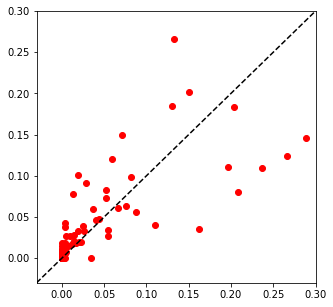

In [72]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(df_rab.loc['ASV_30'], df_mgm.loc['Klebsiella pneumoniae'],'ro')
print(pearsonr(df_rab.loc['ASV_30'], df_mgm.loc['Klebsiella pneumoniae']))
ax.plot([-0.03,0.3],[-0.03,0.3],'k--')
ax.set_xlim([-0.03,0.3])
ax.set_ylim([-0.03,0.3])

(0.3595721460126724, 2.2331177642857598e-13)


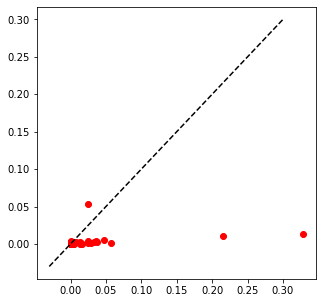

In [60]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(df_rab.loc['ASV_36'], df_mgm.loc['Klebsiella michiganensis'],'ro')
print(pearsonr(df_rab.loc['ASV_36'], df_mgm.loc['Klebsiella michiganensis']))
ax.plot([-0.03,0.3],[-0.03,0.3],'k--')
# ax.plot([-0.015,0.15],[-0.015,0.15],'k--')
# ax.set_xlim([-0.015,0.15])
# ax.set_ylim([-0.015,0.15])

(0.9378534190565719, 6.886081200240983e-181)


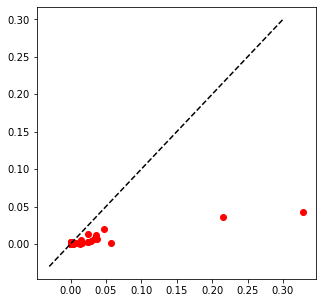

In [67]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(df_rab.loc['ASV_36'], df_mgm.loc['Klebsiella grimontii'],'ro')
print(pearsonr(df_rab.loc['ASV_36'], df_mgm.loc['Klebsiella grimontii']))
ax.plot([-0.03,0.3],[-0.03,0.3],'k--')
# ax.plot([-0.015,0.15],[-0.015,0.15],'k--')
# ax.set_xlim([-0.015,0.15])
# ax.set_ylim([-0.015,0.15])